Dual-Field Language Organism - Example Usage


1. Processing simple text...
Vocabulary size: 34
Epoch 1/3
  Token 0/40: tension=0.0185, valence=0.0018, energy=0.6112
  Adapted operators: α=0.4999, β=0.4999
Epoch 2/3
  Token 0/40: tension=0.0601, valence=0.0089, energy=0.8637
  Adapted operators: α=0.4999, β=0.4999
Epoch 3/3
  Token 0/40: tension=0.1080, valence=0.0138, energy=1.6206
  Adapted operators: α=0.4997, β=0.4997


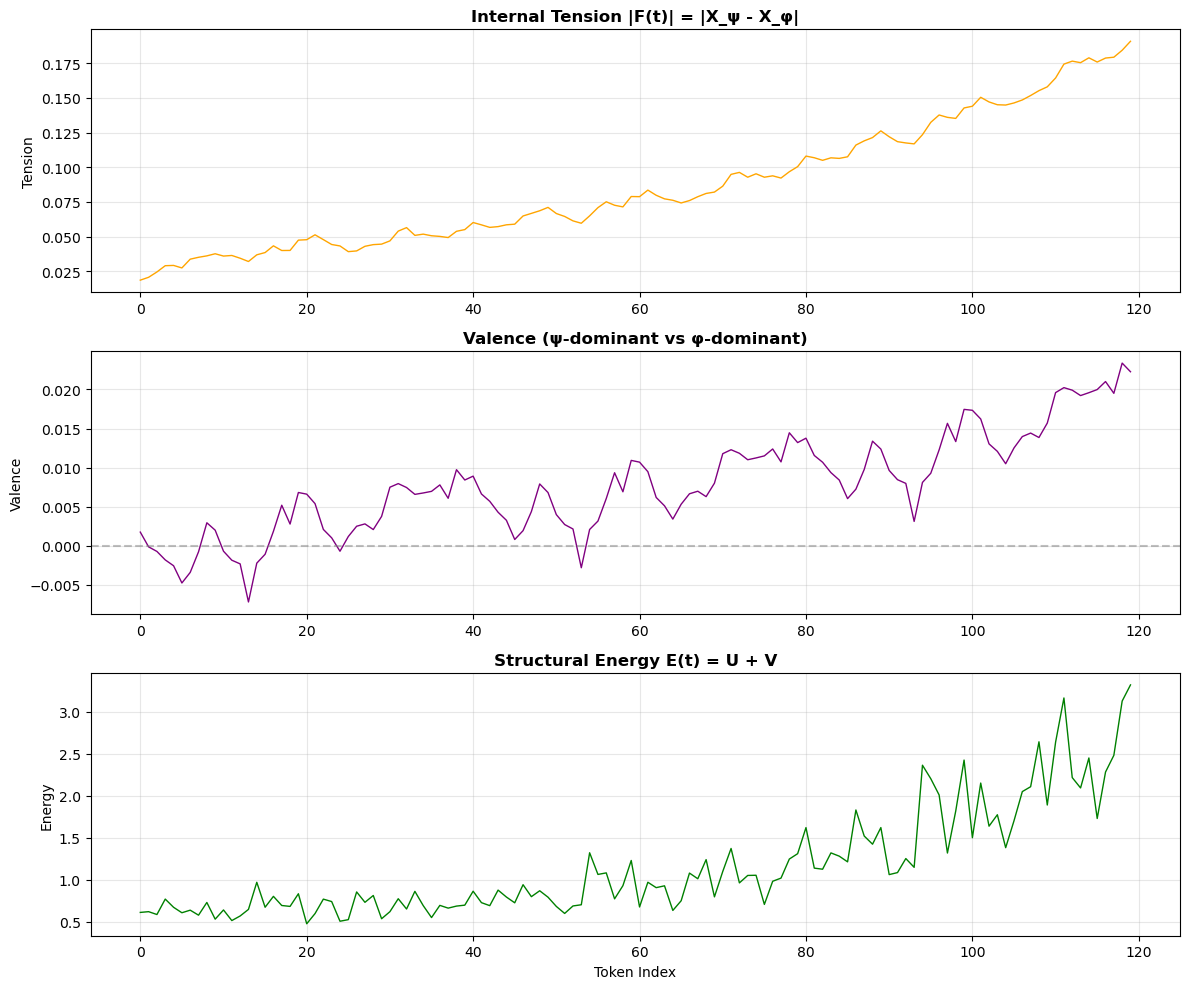

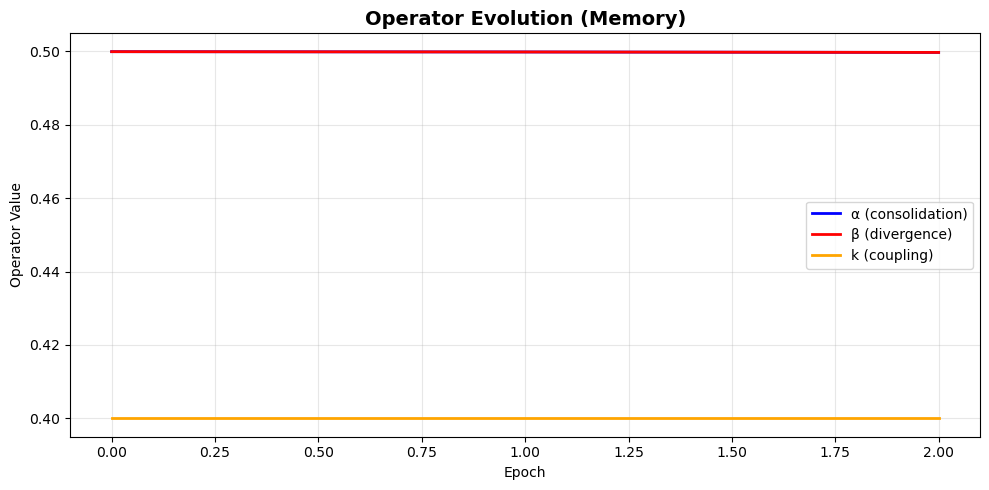

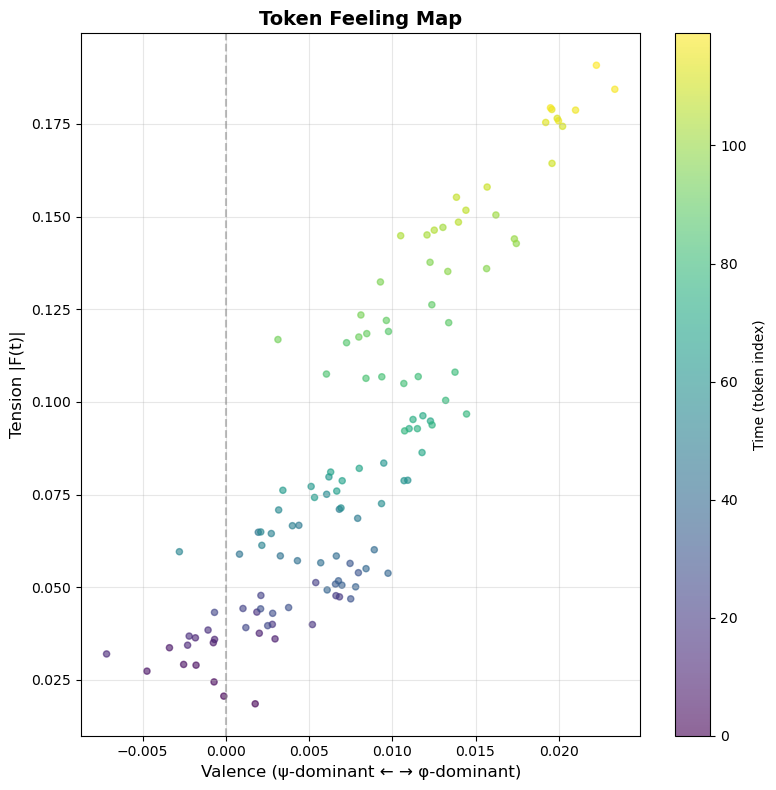


2. To load from file:
   tokens, file_type = auto_load_file('path/to/file.txt')
   organism.process_sequence(tokens, epochs=5)

3. For binary files (like enwik8):
   tokens, _ = auto_load_file('enwik8', max_size=100000)
   # tokens will be byte values 0-255

Notebook ready. Try loading your own data!


In [1]:
"""
Dual-Field Language Organism
A minimal implementation of feeling machines for language learning

Based on: "An Outline of a Theory of Feelings and Feeling Machines"
by Pasquale Caianiello

This notebook implements a dual-field organism that learns language
through the tension between consolidation (φ) and divergence (ψ).
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import struct

# ============================================================================
# FILE LOADING UTILITIES
# ============================================================================

def load_text_file(filepath: str, max_chars: Optional[int] = None) -> str:
    """Load a text file (handles UTF-8, Latin-1, etc.)"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(filepath, 'r', encoding=encoding) as f:
                text = f.read()
                if max_chars:
                    text = text[:max_chars]
                return text
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Could not decode file {filepath} with any known encoding")


def load_binary_file(filepath: str, max_bytes: Optional[int] = None) -> bytes:
    """Load a binary file as raw bytes"""
    with open(filepath, 'rb') as f:
        data = f.read()
        if max_bytes:
            data = data[:max_bytes]
        return data


def load_csv_as_text(filepath: str, max_rows: Optional[int] = None) -> str:
    """Load CSV and convert to text (concatenate all cells)"""
    import csv
    
    text_parts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if max_rows and i >= max_rows:
                break
            text_parts.append(' '.join(row))
    
    return ' '.join(text_parts)


def auto_load_file(filepath: str, max_size: int = 1_000_000) -> Tuple[List, str]:
    """
    Automatically detect file type and load as tokens
    Returns: (tokens, file_type)
    """
    path = Path(filepath)
    suffix = path.suffix.lower()
    
    if suffix == '.txt':
        text = load_text_file(filepath, max_size)
        tokens = tokenize_text(text)
        return tokens, 'text'
    
    elif suffix == '.csv':
        text = load_csv_as_text(filepath, max_size // 100)
        tokens = tokenize_text(text)
        return tokens, 'csv'
    
    else:
        # Treat as binary - use byte values as tokens
        data = load_binary_file(filepath, max_size)
        tokens = list(data)
        return tokens, 'binary'


def tokenize_text(text: str, method: str = 'word') -> List[str]:
    """
    Tokenize text into tokens
    method: 'word' (split on whitespace/punctuation) or 'char' (character-level)
    """
    if method == 'char':
        return list(text)
    
    # Simple word tokenizer
    import re
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())
    return tokens


# ============================================================================
# DUAL-FIELD ORGANISM
# ============================================================================

class DualFieldOrganism:
    """
    A minimal dual-field organism for language learning
    
    Fields:
        X_phi: consolidation field (pulls toward familiar patterns)
        X_psi: divergence field (pushes toward novelty)
    
    Operators (adaptive):
        alpha: consolidation strength
        beta: divergence strength
        lambda_: phi recruitment bias
        mu: psi recruitment bias
        k: coupling strength between fields
    """
    
    def __init__(self, dim: int = 64, vocab_size: int = 1000):
        self.dim = dim
        self.vocab_size = vocab_size
        
        # Dual fields
        self.X_phi = np.random.randn(dim) * 0.01
        self.X_psi = np.random.randn(dim) * 0.01
        
        # Operators (will adapt over time)
        self.alpha = 0.5   # consolidation strength
        self.beta = 0.5    # divergence strength
        self.lambda_ = 0.3 # phi recruitment
        self.mu = 0.3      # psi recruitment
        self.k = 0.4       # coupling
        
        # Vocabulary and embeddings
        self.vocab = {}
        self.embeddings = {}
        
        # History
        self.feeling_history = []
        self.energy_history = []
        self.operator_history = []
        
    def build_vocabulary(self, tokens: List):
        """Build vocabulary and random embeddings from tokens"""
        unique_tokens = list(set(tokens))[:self.vocab_size]
        
        self.vocab = {token: i for i, token in enumerate(unique_tokens)}
        self.embeddings = {
            token: np.random.randn(self.dim) * 0.1 
            for token in unique_tokens
        }
        
        print(f"Vocabulary size: {len(self.vocab)}")
        
    def get_embedding(self, token) -> np.ndarray:
        """Get embedding for a token (or zero vector if unknown)"""
        return self.embeddings.get(token, np.zeros(self.dim))
    
    def compute_potentials(self, token_embedding: np.ndarray) -> Tuple[float, float, float]:
        """
        Compute U (consolidation), V (divergence), and total energy E
        
        U penalizes distance from token embedding (wants to match familiar patterns)
        V rewards distance from token embedding (wants to explore)
        """
        # U: consolidation potential
        diff_phi = self.X_phi - token_embedding
        U = self.alpha * np.sum(diff_phi ** 2) - self.lambda_ * np.sum(self.X_phi ** 2)
        
        # V: divergence potential
        diff_psi = self.X_psi - token_embedding
        V = self.beta * np.sum(diff_psi ** 2) - self.mu * np.sum(self.X_psi ** 2)
        
        E = U + V
        return U, V, E
    
    def compute_gradients(self, token_embedding: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Compute gradients of potentials"""
        grad_U = 2 * self.alpha * (self.X_phi - token_embedding) - 2 * self.lambda_ * self.X_phi
        grad_V = 2 * self.beta * (self.X_psi - token_embedding) - 2 * self.mu * self.X_psi
        return grad_U, grad_V
    
    def step_dynamics(self, token_embedding: np.ndarray, dt: float = 0.01, steps: int = 10):
        """
        Run dual-field dynamics for several timesteps
        
        Equations:
            dX_phi/dt = -∇U(X_phi) + k(X_psi - X_phi)
            dX_psi/dt = +∇V(X_psi) - k(X_psi - X_phi)
        """
        for _ in range(steps):
            grad_U, grad_V = self.compute_gradients(token_embedding)
            
            # Dual-field equations with endogenous regulation
            D = self.X_psi - self.X_phi  # field difference (tension)
            
            # Consolidation field
            dX_phi = -grad_U + self.k * D
            self.X_phi += dt * dX_phi
            
            # Divergence field
            dX_psi = grad_V - self.k * D
            self.X_psi += dt * dX_psi
    
    def compute_feeling(self) -> Dict[str, float]:
        """
        Compute the organism's current feeling
        
        Returns:
            tension: |X_psi - X_phi| (magnitude of internal conflict)
            valence: sign(X_psi - X_phi) (direction: exploration vs consolidation)
        """
        F = self.X_psi - self.X_phi
        tension = np.mean(np.abs(F))
        valence = np.mean(F)
        return {'tension': tension, 'valence': valence}
    
    def process_token(self, token) -> Dict[str, float]:
        """Process a single token and return feelings"""
        embedding = self.get_embedding(token)
        
        # Run dynamics
        self.step_dynamics(embedding)
        
        # Compute feelings
        feelings = self.compute_feeling()
        U, V, E = self.compute_potentials(embedding)
        
        # Record history
        self.feeling_history.append({
            'token': token,
            'tension': feelings['tension'],
            'valence': feelings['valence'],
            'energy': E
        })
        self.energy_history.append(E)
        
        return {**feelings, 'energy': E}
    
    def adapt_operators(self, learning_rate: float = 0.01):
        """
        Adapt operators based on recent energy
        This is where memory lives - not in stored representations,
        but in how the organism will respond next time
        """
        if len(self.energy_history) < 10:
            return
        
        # Use recent average energy for gradient
        recent_energy = np.mean(self.energy_history[-100:])
        
        # Simple gradient descent on operators
        self.alpha = max(0.1, self.alpha - learning_rate * recent_energy * 0.01)
        self.beta = max(0.1, self.beta - learning_rate * recent_energy * 0.01)
        
        # Record operator state
        self.operator_history.append({
            'alpha': self.alpha,
            'beta': self.beta,
            'k': self.k
        })
    
    def process_sequence(self, tokens: List, epochs: int = 1, verbose: bool = True):
        """Process a sequence of tokens for multiple epochs"""
        if not self.vocab:
            self.build_vocabulary(tokens)
        
        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}")
            
            for i, token in enumerate(tokens):
                self.process_token(token)
                
                if verbose and i % 100 == 0:
                    recent = self.feeling_history[-1]
                    print(f"  Token {i}/{len(tokens)}: "
                          f"tension={recent['tension']:.4f}, "
                          f"valence={recent['valence']:.4f}, "
                          f"energy={recent['energy']:.4f}")
            
            # Adapt operators at end of epoch
            self.adapt_operators()
            
            if verbose:
                print(f"  Adapted operators: α={self.alpha:.4f}, β={self.beta:.4f}")


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_feelings(organism: DualFieldOrganism, window: int = 500):
    """Plot the organism's feeling trajectory"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    indices = range(len(history))
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    energies = [h['energy'] for h in history]
    
    # Tension
    axes[0].plot(indices, tensions, color='orange', linewidth=1)
    axes[0].set_title('Internal Tension |F(t)| = |X_ψ - X_φ|', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Tension')
    axes[0].grid(alpha=0.3)
    
    # Valence
    axes[1].plot(indices, valences, color='purple', linewidth=1)
    axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Valence (ψ-dominant vs φ-dominant)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Valence')
    axes[1].grid(alpha=0.3)
    
    # Energy
    axes[2].plot(indices, energies, color='green', linewidth=1)
    axes[2].set_title('Structural Energy E(t) = U + V', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Token Index')
    axes[2].set_ylabel('Energy')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_operators(organism: DualFieldOrganism):
    """Plot operator evolution over epochs"""
    history = organism.operator_history
    
    if len(history) == 0:
        print("No operator history to plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    epochs = range(len(history))
    alphas = [h['alpha'] for h in history]
    betas = [h['beta'] for h in history]
    ks = [h['k'] for h in history]
    
    ax.plot(epochs, alphas, label='α (consolidation)', color='blue', linewidth=2)
    ax.plot(epochs, betas, label='β (divergence)', color='red', linewidth=2)
    ax.plot(epochs, ks, label='k (coupling)', color='orange', linewidth=2)
    
    ax.set_title('Operator Evolution (Memory)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Operator Value')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_feeling_distribution(organism: DualFieldOrganism, window: int = 500):
    """Plot 2D distribution of feelings (tension vs valence)"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    scatter = ax.scatter(valences, tensions, c=range(len(tensions)), 
                        cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel('Valence (ψ-dominant ← → φ-dominant)', fontsize=12)
    ax.set_ylabel('Tension |F(t)|', fontsize=12)
    ax.set_title('Token Feeling Map', fontsize=14, fontweight='bold')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.grid(alpha=0.3)
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("Dual-Field Language Organism - Example Usage\n")
    print("=" * 60)
    
    # Example 1: Simple text
    print("\n1. Processing simple text...")
    text = """
    The quick brown fox jumps over the lazy dog.
    This is a test of the dual-field language organism.
    It learns not by prediction, but by feeling the tension
    between familiar patterns and novel structures.
    """
    
    tokens = tokenize_text(text)
    organism = DualFieldOrganism(dim=64, vocab_size=1000)
    organism.process_sequence(tokens, epochs=3, verbose=True)
    
    plot_feelings(organism)
    plot_operators(organism)
    plot_feeling_distribution(organism)
    
    # Example 2: Load from file
    print("\n2. To load from file:")
    print("   tokens, file_type = auto_load_file('path/to/file.txt')")
    print("   organism.process_sequence(tokens, epochs=5)")
    
    # Example 3: Binary data
    print("\n3. For binary files (like enwik8):")
    print("   tokens, _ = auto_load_file('enwik8', max_size=100000)")
    print("   # tokens will be byte values 0-255")
    
    print("\n" + "=" * 60)
    print("Notebook ready. Try loading your own data!")

Vocabulary size: 52
Epoch 1/10
  Token 0/1000: tension=1.4336, valence=0.1368, energy=0.1533
  Token 100/1000: tension=0.0018, valence=1.0000, energy=0.0906
  Token 200/1000: tension=0.0000, valence=1.0000, energy=0.0721
  Token 300/1000: tension=0.0000, valence=1.0000, energy=-0.4365
  Token 400/1000: tension=0.0000, valence=1.0000, energy=-0.2528
  Token 500/1000: tension=0.0000, valence=1.0000, energy=-0.2072
  Token 600/1000: tension=0.0000, valence=1.0000, energy=-0.1222
  Token 700/1000: tension=0.0000, valence=1.0000, energy=-0.4714
  Token 800/1000: tension=0.0000, valence=1.0000, energy=-0.5130
  Token 900/1000: tension=0.0000, valence=1.0000, energy=-0.2729
  Adapted operators: α=0.2000, β=0.2000
Epoch 2/10
  Token 0/1000: tension=0.0000, valence=1.0000, energy=-0.0080
  Token 100/1000: tension=0.0000, valence=1.0000, energy=0.0906
  Token 200/1000: tension=0.0000, valence=1.0000, energy=0.0722
  Token 300/1000: tension=0.0000, valence=1.0000, energy=-0.4365
  Token 400/1000:

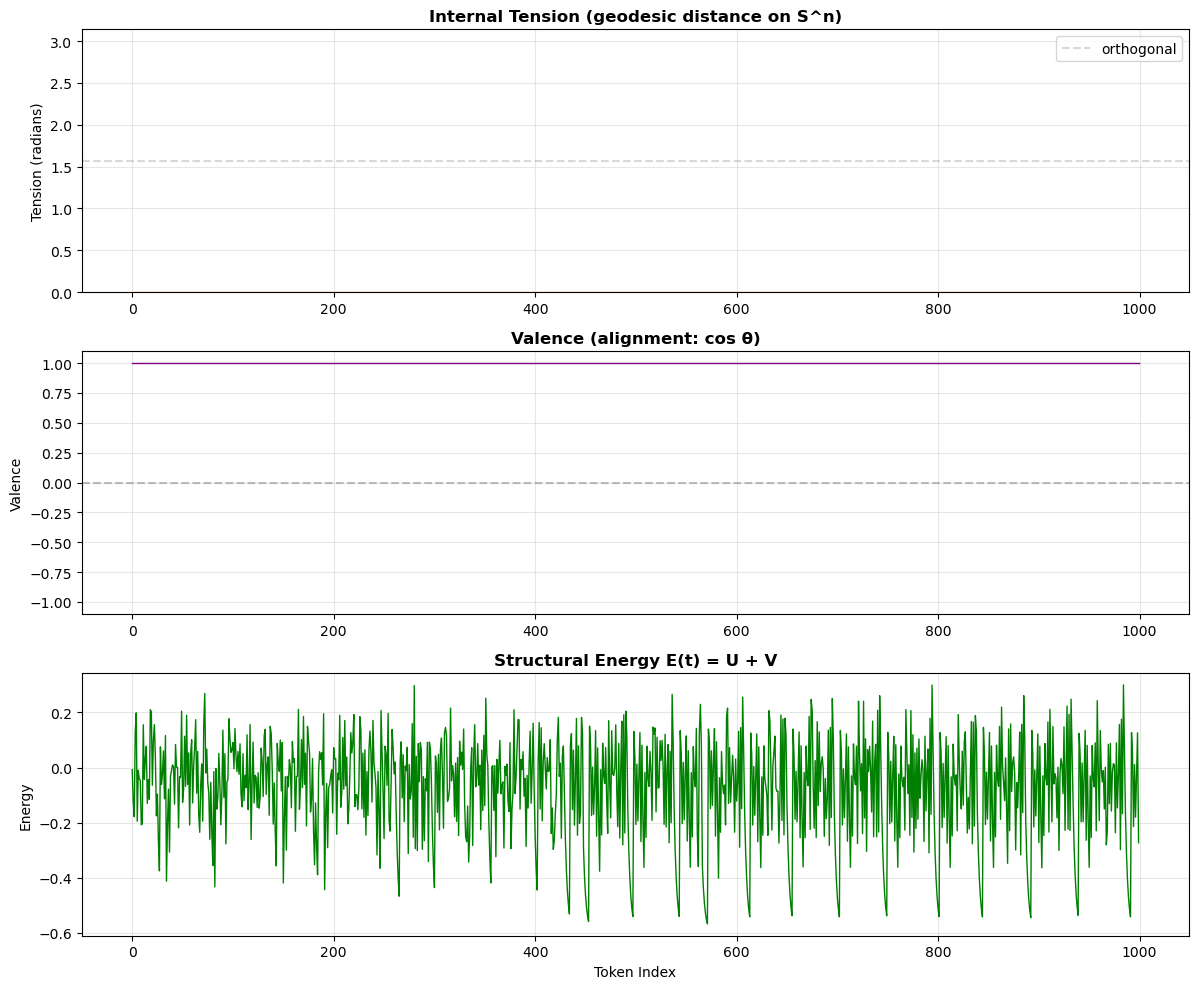

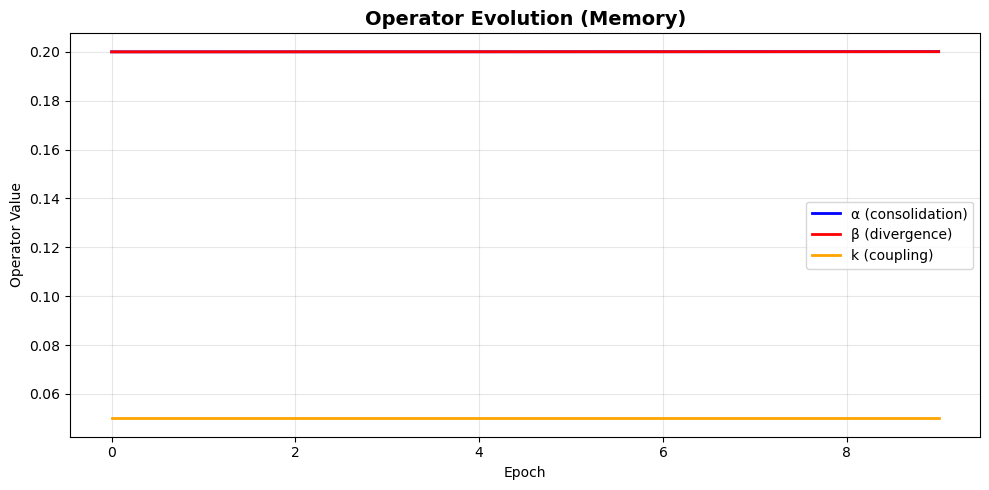

In [9]:
# Load first 100k bytes
tokens, _ = auto_load_file('enwik8_10M', max_size=1000)

organism = DualFieldOrganism(dim=64, vocab_size=256)  # 256 for byte values
organism.process_sequence(tokens, epochs=10)

plot_feelings(organism, window=1000)
plot_operators(organism)

Dual-Field Language Organism - Spherical Version

Fields live on unit sphere S^n - self-regulating geometry
Tension = geodesic distance | Valence = angular alignment

1. Processing simple text...
Vocabulary size: 33
Epoch 1/3
  Token 0/290: tension=1.2909, valence=0.2762, energy=2.8606
  Token 100/290: tension=0.0000, valence=1.0000, energy=2.1223
  Token 200/290: tension=0.0000, valence=1.0000, energy=0.9577
  Adapted operators: α=1.1998, β=1.1998
Epoch 2/3
  Token 0/290: tension=0.0000, valence=1.0000, energy=2.0899
  Token 100/290: tension=0.0000, valence=1.0000, energy=2.1221
  Token 200/290: tension=0.0000, valence=1.0000, energy=0.9577
  Adapted operators: α=1.1996, β=1.1996
Epoch 3/3
  Token 0/290: tension=0.0000, valence=1.0000, energy=2.0898
  Token 100/290: tension=0.0000, valence=1.0000, energy=2.1220
  Token 200/290: tension=0.0000, valence=1.0000, energy=0.9576
  Adapted operators: α=1.1994, β=1.1994


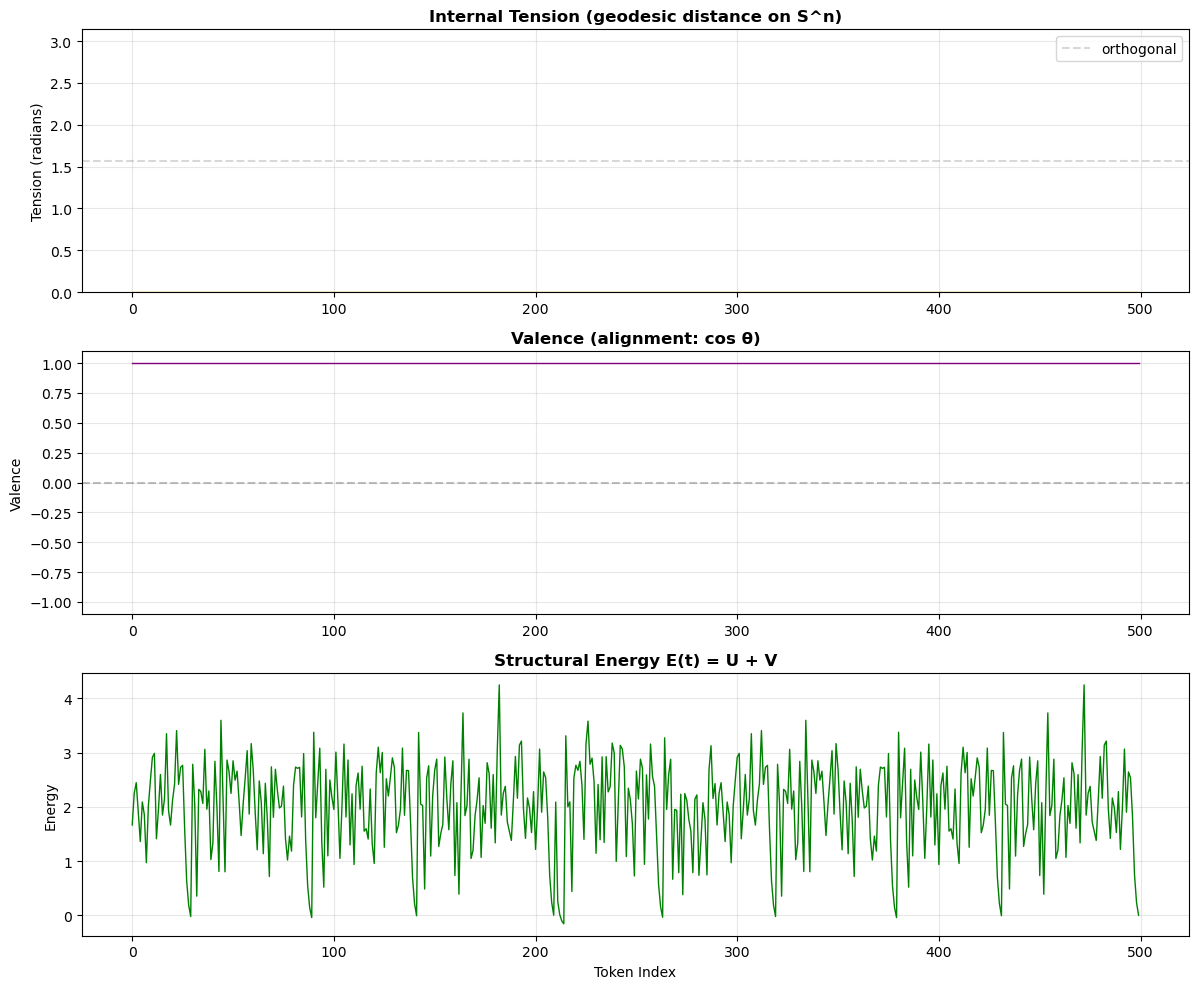

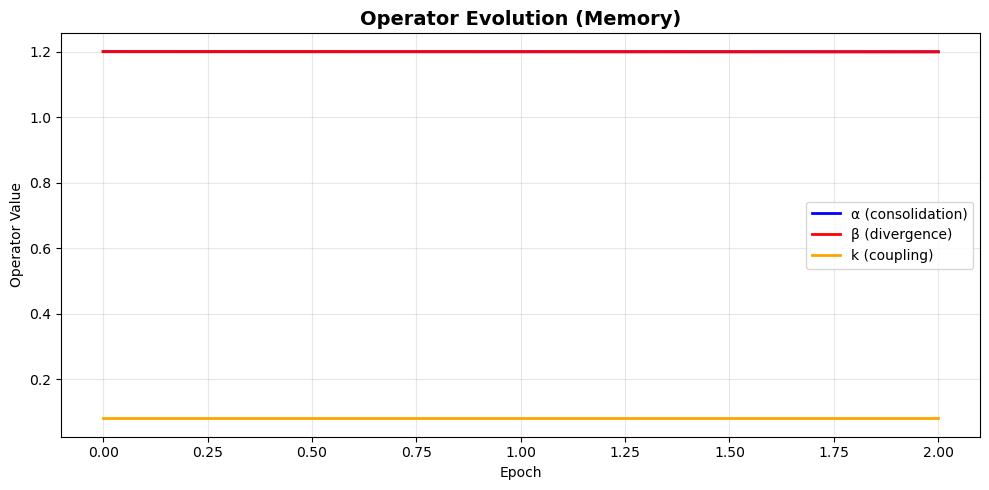

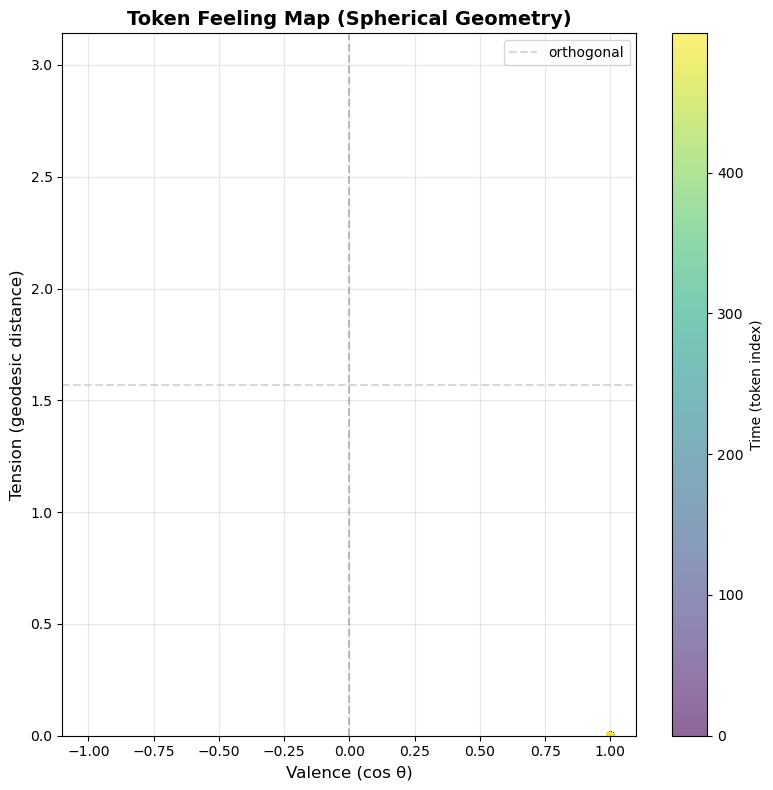


2. To load from file:
   tokens, file_type = auto_load_file('path/to/file.txt')
   organism.process_sequence(tokens, epochs=5)

3. For binary files (like enwik8):
   tokens, _ = auto_load_file('enwik8', max_size=100000)
   organism = DualFieldOrganism(dim=64, vocab_size=256)
   organism.process_sequence(tokens, epochs=10)

   Fields will stay bounded on sphere - no explosions!

Notebook ready. The geometry is self-regulating.


In [12]:
"""
Dual-Field Language Organism
A minimal implementation of feeling machines for language learning

Based on: "An Outline of a Theory of Feelings and Feeling Machines"
by Pasquale Caianiello

This notebook implements a dual-field organism that learns language
through the tension between consolidation (φ) and divergence (ψ).

KEY FEATURE: Fields live on unit sphere (S^n) - self-regulating geometry
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import struct

# ============================================================================
# FILE LOADING UTILITIES
# ============================================================================

def load_text_file(filepath: str, max_chars: Optional[int] = None) -> str:
    """Load a text file (handles UTF-8, Latin-1, etc.)"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(filepath, 'r', encoding=encoding) as f:
                text = f.read()
                if max_chars:
                    text = text[:max_chars]
                return text
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Could not decode file {filepath} with any known encoding")


def load_binary_file(filepath: str, max_bytes: Optional[int] = None) -> bytes:
    """Load a binary file as raw bytes"""
    with open(filepath, 'rb') as f:
        data = f.read()
        if max_bytes:
            data = data[:max_bytes]
        return data


def load_csv_as_text(filepath: str, max_rows: Optional[int] = None) -> str:
    """Load CSV and convert to text (concatenate all cells)"""
    import csv
    
    text_parts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if max_rows and i >= max_rows:
                break
            text_parts.append(' '.join(row))
    
    return ' '.join(text_parts)


def auto_load_file(filepath: str, max_size: int = 1_000_000) -> Tuple[List, str]:
    """
    Automatically detect file type and load as tokens
    Returns: (tokens, file_type)
    """
    path = Path(filepath)
    suffix = path.suffix.lower()
    
    if suffix == '.txt':
        text = load_text_file(filepath, max_size)
        tokens = tokenize_text(text)
        return tokens, 'text'
    
    elif suffix == '.csv':
        text = load_csv_as_text(filepath, max_size // 100)
        tokens = tokenize_text(text)
        return tokens, 'csv'
    
    else:
        # Treat as binary - use byte values as tokens
        data = load_binary_file(filepath, max_size)
        tokens = list(data)
        return tokens, 'binary'


def tokenize_text(text: str, method: str = 'char') -> List[str]:
    """
    Tokenize text into tokens
    method: 'word' (split on whitespace/punctuation) or 'char' (character-level)
    """
    if method == 'char':
        return list(text)
    
    # Simple word tokenizer
    import re
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())
    return tokens


# ============================================================================
# GEOMETRIC UTILITIES
# ============================================================================

def normalize_to_sphere(x: np.ndarray) -> np.ndarray:
    """Project vector onto unit sphere"""
    norm = np.linalg.norm(x)
    if norm < 1e-10:  # Handle zero vector
        return x
    return x / norm


def geodesic_distance(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute geodesic (great circle) distance between two points on unit sphere
    This is the natural notion of distance when fields live on S^n
    """
    # Ensure on sphere
    x = normalize_to_sphere(x)
    y = normalize_to_sphere(y)
    
    # Compute angle via dot product
    dot = np.clip(np.dot(x, y), -1.0, 1.0)
    return np.arccos(dot)


# ============================================================================
# DUAL-FIELD ORGANISM (SPHERICAL VERSION)
# ============================================================================

class DualFieldOrganism:
    """
    A minimal dual-field organism for language learning
    
    Fields:
        X_phi: consolidation field (pulls toward familiar patterns) - lives on S^n
        X_psi: divergence field (pushes toward novelty) - lives on S^n
    
    Operators (adaptive):
        alpha: consolidation strength
        beta: divergence strength
        lambda_: phi recruitment bias
        mu: psi recruitment bias
        k: coupling strength between fields
    
    KEY: Fields are constrained to unit sphere - self-regulating geometry
    """
    
    def __init__(self, dim: int = 64, vocab_size: int = 1000):
        self.dim = dim
        self.vocab_size = vocab_size
        
        # Dual fields - initialize on sphere
        self.X_phi = normalize_to_sphere(np.random.randn(dim))
        self.X_psi = normalize_to_sphere(np.random.randn(dim))
        
        # Operators (will adapt over time)
        self.alpha = 1.2   # consolidation strength
        self.beta = 1.2    # divergence strength
        self.lambda_ = 0.1 # phi recruitment
        self.mu = 0.1      # psi recruitment
        self.k = 0.08       # coupling
        
        # Vocabulary and embeddings (also on sphere)
        self.vocab = {}
        self.embeddings = {}
        
        # History
        self.feeling_history = []
        self.energy_history = []
        self.operator_history = []
        
    def build_vocabulary(self, tokens: List):
        """Build vocabulary and random embeddings from tokens (on sphere)"""
        unique_tokens = list(set(tokens))[:self.vocab_size]
        
        self.vocab = {token: i for i, token in enumerate(unique_tokens)}
        self.embeddings = {
            token: normalize_to_sphere(np.random.randn(self.dim))
            for token in unique_tokens
        }
        
        print(f"Vocabulary size: {len(self.vocab)}")
        
    def get_embedding(self, token) -> np.ndarray:
        """Get embedding for a token (or random direction if unknown)"""
        if token not in self.embeddings:
            return normalize_to_sphere(np.random.randn(self.dim))
        return self.embeddings[token]
    
    def compute_potentials(self, token_embedding: np.ndarray) -> Tuple[float, float, float]:
        """
        Compute U (consolidation), V (divergence), and total energy E
        
        On the sphere, we use geodesic distance instead of Euclidean
        U penalizes angular distance from token (wants to align)
        V rewards angular distance from token (wants to diverge)
        """
        # Geodesic distances
        dist_phi = geodesic_distance(self.X_phi, token_embedding)
        dist_psi = geodesic_distance(self.X_psi, token_embedding)
        
        # U: consolidation potential (penalizes distance)
        U = self.alpha * (dist_phi ** 2) - self.lambda_
        
        # V: divergence potential (rewards distance)
        V = self.beta * (dist_psi ** 2) - self.mu
        
        E = U + V
        return U, V, E
    
    def compute_tangent_gradients(self, token_embedding: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute gradients in tangent space to sphere
        This ensures the dynamics stay on the manifold
        """
        # Gradient on sphere is projection to tangent space
        # For U = alpha * dist^2, gradient points from X toward target
        
        # Direction toward/away from token
        toward_token_phi = token_embedding - np.dot(self.X_phi, token_embedding) * self.X_phi
        toward_token_psi = token_embedding - np.dot(self.X_psi, token_embedding) * self.X_psi
        
        # Normalize to tangent vectors
        norm_phi = np.linalg.norm(toward_token_phi)
        norm_psi = np.linalg.norm(toward_token_psi)
        
        if norm_phi > 1e-10:
            toward_token_phi = toward_token_phi / norm_phi
        if norm_psi > 1e-10:
            toward_token_psi = toward_token_psi / norm_psi
        
        # Consolidation gradient: toward token
        grad_U_tangent = -2 * self.alpha * geodesic_distance(self.X_phi, token_embedding) * toward_token_phi
        
        # Divergence gradient: away from token  
        grad_V_tangent = 2 * self.beta * geodesic_distance(self.X_psi, token_embedding) * toward_token_psi
        
        return grad_U_tangent, grad_V_tangent
    
    def step_dynamics(self, token_embedding: np.ndarray, dt: float = 0.05, steps: int = 3):
        """
        Run dual-field dynamics for several timesteps ON THE SPHERE
        
        Equations (in tangent space):
            dX_phi/dt = -∇U(X_phi) + k * project_tangent(X_psi - X_phi)
            dX_psi/dt = +∇V(X_psi) - k * project_tangent(X_psi - X_phi)
        
        After each step, renormalize to stay on sphere
        """
        for _ in range(steps):
            grad_U, grad_V = self.compute_tangent_gradients(token_embedding)
            
            # Field difference projected to tangent spaces
            # On sphere, "difference" is the tangent vector pointing from one to the other
            D_phi = self.X_psi - np.dot(self.X_phi, self.X_psi) * self.X_phi  # tangent at phi
            D_psi = self.X_phi - np.dot(self.X_psi, self.X_phi) * self.X_psi  # tangent at psi
            
            # Dual-field equations
            dX_phi = -grad_U + self.k * D_phi
            dX_psi = grad_V - self.k * D_psi
            
            # Update (Euler step in tangent space)
            self.X_phi += dt * dX_phi
            self.X_psi += dt * dX_psi
            
            # Renormalize to sphere (self-regulation)
            self.X_phi = normalize_to_sphere(self.X_phi)
            self.X_psi = normalize_to_sphere(self.X_psi)
    
    def compute_feeling(self) -> Dict[str, float]:
        """
        Compute the organism's current feeling
        
        On sphere:
            tension: geodesic distance between fields (angular separation)
            valence: signed projection (which field dominates direction)
        """
        # Geodesic distance as tension
        tension = geodesic_distance(self.X_phi, self.X_psi)
        
        # Valence: dot product (positive = aligned, negative = opposed)
        valence = np.dot(self.X_phi, self.X_psi)
        
        return {'tension': tension, 'valence': valence}
    
    def process_token(self, token) -> Dict[str, float]:
        """Process a single token and return feelings"""
        embedding = self.get_embedding(token)
        
        # Run dynamics
        self.step_dynamics(embedding)
        
        # Compute feelings
        feelings = self.compute_feeling()
        U, V, E = self.compute_potentials(embedding)
        
        # Record history
        self.feeling_history.append({
            'token': token,
            'tension': feelings['tension'],
            'valence': feelings['valence'],
            'energy': E
        })
        self.energy_history.append(E)
        
        return {**feelings, 'energy': E}
    
    def adapt_operators(self, learning_rate: float = 0.01):
        """
        Adapt operators based on recent energy
        This is where memory lives - not in stored representations,
        but in how the organism will respond next time
        """
        if len(self.energy_history) < 10:
            return
        
        # Use recent average energy for gradient
        recent_energy = np.mean(self.energy_history[-100:])
        
        # Simple gradient descent on operators
        self.alpha = max(0.1, self.alpha - learning_rate * recent_energy * 0.01)
        self.beta = max(0.1, self.beta - learning_rate * recent_energy * 0.01)
        
        # Record operator state
        self.operator_history.append({
            'alpha': self.alpha,
            'beta': self.beta,
            'k': self.k
        })
    
    def process_sequence(self, tokens: List, epochs: int = 1, verbose: bool = True):
        """Process a sequence of tokens for multiple epochs"""
        if not self.vocab:
            self.build_vocabulary(tokens)
        
        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}")
            
            for i, token in enumerate(tokens):
                self.process_token(token)
                
                if verbose and i % 100 == 0:
                    recent = self.feeling_history[-1]
                    print(f"  Token {i}/{len(tokens)}: "
                          f"tension={recent['tension']:.4f}, "
                          f"valence={recent['valence']:.4f}, "
                          f"energy={recent['energy']:.4f}")
            
            # Adapt operators at end of epoch
            self.adapt_operators()
            
            if verbose:
                print(f"  Adapted operators: α={self.alpha:.4f}, β={self.beta:.4f}")


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_feelings(organism: DualFieldOrganism, window: int = 500):
    """Plot the organism's feeling trajectory"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    indices = range(len(history))
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    energies = [h['energy'] for h in history]
    
    # Tension (geodesic distance)
    axes[0].plot(indices, tensions, color='orange', linewidth=1)
    axes[0].set_title('Internal Tension (geodesic distance on S^n)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Tension (radians)')
    axes[0].set_ylim([0, np.pi])  # Max geodesic distance on sphere
    axes[0].axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # Valence (dot product)
    axes[1].plot(indices, valences, color='purple', linewidth=1)
    axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Valence (alignment: cos θ)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Valence')
    axes[1].set_ylim([-1.1, 1.1])
    axes[1].grid(alpha=0.3)
    
    # Energy
    axes[2].plot(indices, energies, color='green', linewidth=1)
    axes[2].set_title('Structural Energy E(t) = U + V', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Token Index')
    axes[2].set_ylabel('Energy')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_operators(organism: DualFieldOrganism):
    """Plot operator evolution over epochs"""
    history = organism.operator_history
    
    if len(history) == 0:
        print("No operator history to plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    epochs = range(len(history))
    alphas = [h['alpha'] for h in history]
    betas = [h['beta'] for h in history]
    ks = [h['k'] for h in history]
    
    ax.plot(epochs, alphas, label='α (consolidation)', color='blue', linewidth=2)
    ax.plot(epochs, betas, label='β (divergence)', color='red', linewidth=2)
    ax.plot(epochs, ks, label='k (coupling)', color='orange', linewidth=2)
    
    ax.set_title('Operator Evolution (Memory)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Operator Value')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_feeling_distribution(organism: DualFieldOrganism, window: int = 500):
    """Plot 2D distribution of feelings (tension vs valence)"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    scatter = ax.scatter(valences, tensions, c=range(len(tensions)), 
                        cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel('Valence (cos θ)', fontsize=12)
    ax.set_ylabel('Tension (geodesic distance)', fontsize=12)
    ax.set_title('Token Feeling Map (Spherical Geometry)', fontsize=14, fontweight='bold')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([0, np.pi])
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


def plot_3d_trajectory(organism: DualFieldOrganism, window: int = 100):
    """
    Plot 3D trajectory of fields (using first 3 dimensions as proxy)
    Shows how the fields move on the sphere
    """
    history = organism.feeling_history[-window:]
    
    if len(history) == 0 or organism.dim < 3:
        print("Need at least 3 dimensions and some history")
        return
    
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 5))
    
    # Draw unit sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Reconstruct trajectories (this is a simplification - we'd need to store full history)
    # For now just show current position
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')
    ax.scatter([organism.X_phi[0]], [organism.X_phi[1]], [organism.X_phi[2]], 
               c='blue', s=100, label='φ (consolidation)')
    ax.scatter([organism.X_psi[0]], [organism.X_psi[1]], [organism.X_psi[2]], 
               c='red', s=100, label='ψ (divergence)')
    ax.set_title('Current Field Positions on S²')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("Dual-Field Language Organism - Spherical Version\n")
    print("=" * 60)
    print("Fields live on unit sphere S^n - self-regulating geometry")
    print("Tension = geodesic distance | Valence = angular alignment")
    print("=" * 60)
    
    # Example 1: Simple text
    print("\n1. Processing simple text...")
    text = """
    The quick brown fox jumps over the lazy dog.
    This is a test of the dual-field language organism.
    It learns not by prediction, but by feeling the tension
    between familiar patterns and novel structures.
    The fields live on a sphere and self-regulate through geometry.
    """
    
    tokens = tokenize_text(text)
    organism = DualFieldOrganism(dim=64, vocab_size=1000)
    organism.process_sequence(tokens, epochs=3, verbose=True)
    
    plot_feelings(organism)
    plot_operators(organism)
    plot_feeling_distribution(organism)
    
    # Example 2: Load from file
    print("\n2. To load from file:")
    print("   tokens, file_type = auto_load_file('path/to/file.txt')")
    print("   organism.process_sequence(tokens, epochs=5)")
    
    # Example 3: Binary data (like enwik8)
    print("\n3. For binary files (like enwik8):")
    print("   tokens, _ = auto_load_file('enwik8', max_size=100000)")
    print("   organism = DualFieldOrganism(dim=64, vocab_size=256)")
    print("   organism.process_sequence(tokens, epochs=10)")
    print("\n   Fields will stay bounded on sphere - no explosions!")
    
    print("\n" + "=" * 60)
    print("Notebook ready. The geometry is self-regulating.")

In [15]:
"""
Dual-Field Language Organism
A minimal implementation of feeling machines for language learning

Based on: "An Outline of a Theory of Feelings and Feeling Machines"
by Pasquale Caianiello

This notebook implements a dual-field organism that learns language
through the tension between consolidation (φ) and divergence (ψ).

KEY FEATURES: 
- Fields live on unit sphere (S^n) - self-regulating geometry
- Adaptive coupling based on current tension - endogenous regulation
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import struct

# ============================================================================
# TWEAKING PARAMETERS - ADJUST THESE TO EXPERIMENT
# ============================================================================

class OrganismConfig:
    """
    All adjustable parameters in one place for easy experimentation
    """
    # Field dimension and vocabulary
    DIM = 64                    # Dimensionality of state space
    VOCAB_SIZE = 1000          # Maximum vocabulary size
    
    # Initial operator values (will adapt during learning)
    ALPHA_INIT = 1.5           # Initial consolidation strength
    BETA_INIT = 1.5            # Initial divergence strength
    LAMBDA_INIT = 0.1          # Initial phi recruitment bias
    MU_INIT = 0.1              # Initial psi recruitment bias
    K_INIT = 0.08              # Initial coupling strength (base value)
    
    # Adaptive coupling parameters
    ADAPTIVE_COUPLING = True   # Enable tension-modulated coupling?
    COUPLING_SCALE = 2.0       # Scale factor for tanh in adaptive coupling
    
    # Dynamics integration
    DT = 0.03                  # Time step for integration
    INTEGRATION_STEPS = 5      # Number of steps per token
    
    # Operator adaptation
    LEARNING_RATE = 0.01       # How fast operators adapt
    ADAPTATION_WINDOW = 100    # Number of recent tokens to average for adaptation
    
    # Optional: Momentum (set to 0 to disable)
    USE_MOMENTUM = False       # Enable momentum/inertia?
    MOMENTUM_FACTOR = 0.7      # Momentum coefficient (0 = no momentum, 1 = all momentum)


# ============================================================================
# FILE LOADING UTILITIES
# ============================================================================

def load_text_file(filepath: str, max_chars: Optional[int] = None) -> str:
    """Load a text file (handles UTF-8, Latin-1, etc.)"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(filepath, 'r', encoding=encoding) as f:
                text = f.read()
                if max_chars:
                    text = text[:max_chars]
                return text
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Could not decode file {filepath} with any known encoding")


def load_binary_file(filepath: str, max_bytes: Optional[int] = None) -> bytes:
    """Load a binary file as raw bytes"""
    with open(filepath, 'rb') as f:
        data = f.read()
        if max_bytes:
            data = data[:max_bytes]
        return data


def load_csv_as_text(filepath: str, max_rows: Optional[int] = None) -> str:
    """Load CSV and convert to text (concatenate all cells)"""
    import csv
    
    text_parts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if max_rows and i >= max_rows:
                break
            text_parts.append(' '.join(row))
    
    return ' '.join(text_parts)


def auto_load_file(filepath: str, max_size: int = 1_000_000) -> Tuple[List, str]:
    """
    Automatically detect file type and load as tokens
    Returns: (tokens, file_type)
    """
    path = Path(filepath)
    suffix = path.suffix.lower()
    
    if suffix == '.txt':
        text = load_text_file(filepath, max_size)
        tokens = tokenize_text(text)
        return tokens, 'text'
    
    elif suffix == '.csv':
        text = load_csv_as_text(filepath, max_size // 100)
        tokens = tokenize_text(text)
        return tokens, 'csv'
    
    else:
        # Treat as binary - use byte values as tokens
        data = load_binary_file(filepath, max_size)
        tokens = list(data)
        return tokens, 'binary'


def tokenize_text(text: str, method: str = 'word') -> List[str]:
    """
    Tokenize text into tokens
    method: 'word' (split on whitespace/punctuation) or 'char' (character-level)
    """
    if method == 'char':
        return list(text)
    
    # Simple word tokenizer
    import re
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())
    return tokens


# ============================================================================
# GEOMETRIC UTILITIES
# ============================================================================

def normalize_to_sphere(x: np.ndarray) -> np.ndarray:
    """Project vector onto unit sphere"""
    norm = np.linalg.norm(x)
    if norm < 1e-10:  # Handle zero vector
        return x
    return x / norm


def geodesic_distance(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute geodesic (great circle) distance between two points on unit sphere
    This is the natural notion of distance when fields live on S^n
    """
    # Ensure on sphere
    x = normalize_to_sphere(x)
    y = normalize_to_sphere(y)
    
    # Compute angle via dot product
    dot = np.clip(np.dot(x, y), -1.0, 1.0)
    return np.arccos(dot)


# ============================================================================
# DUAL-FIELD ORGANISM (SPHERICAL VERSION WITH ADAPTIVE COUPLING)
# ============================================================================

class DualFieldOrganism:
    """
    A minimal dual-field organism for language learning
    
    Fields:
        X_phi: consolidation field (pulls toward familiar patterns) - lives on S^n
        X_psi: divergence field (pushes toward novelty) - lives on S^n
    
    Operators (adaptive):
        alpha: consolidation strength
        beta: divergence strength
        lambda_: phi recruitment bias
        mu: psi recruitment bias
        k: coupling strength between fields
    
    KEY: 
    - Fields are constrained to unit sphere - self-regulating geometry
    - Coupling adapts based on current tension - endogenous regulation
    """
    
    def __init__(self, config: OrganismConfig = None):
        if config is None:
            config = OrganismConfig()
        
        self.config = config
        self.dim = config.DIM
        self.vocab_size = config.VOCAB_SIZE
        
        # Dual fields - initialize on sphere
        self.X_phi = normalize_to_sphere(np.random.randn(self.dim))
        self.X_psi = normalize_to_sphere(np.random.randn(self.dim))
        
        # Momentum (if enabled)
        self.velocity_phi = np.zeros(self.dim)
        self.velocity_psi = np.zeros(self.dim)
        
        # Operators (will adapt over time)
        self.alpha = config.ALPHA_INIT
        self.beta = config.BETA_INIT
        self.lambda_ = config.LAMBDA_INIT
        self.mu = config.MU_INIT
        self.k = config.K_INIT
        
        # Vocabulary and embeddings (also on sphere)
        self.vocab = {}
        self.embeddings = {}
        
        # History
        self.feeling_history = []
        self.energy_history = []
        self.operator_history = []
        self.coupling_history = []  # Track effective coupling
        
    def build_vocabulary(self, tokens: List):
        """Build vocabulary and random embeddings from tokens (on sphere)"""
        unique_tokens = list(set(tokens))[:self.vocab_size]
        
        self.vocab = {token: i for i, token in enumerate(unique_tokens)}
        self.embeddings = {
            token: normalize_to_sphere(np.random.randn(self.dim))
            for token in unique_tokens
        }
        
        print(f"Vocabulary size: {len(self.vocab)}")
        
    def get_embedding(self, token) -> np.ndarray:
        """Get embedding for a token (or random direction if unknown)"""
        if token not in self.embeddings:
            return normalize_to_sphere(np.random.randn(self.dim))
        return self.embeddings[token]
    
    def compute_potentials(self, token_embedding: np.ndarray) -> Tuple[float, float, float]:
        """
        Compute U (consolidation), V (divergence), and total energy E
        
        On the sphere, we use geodesic distance instead of Euclidean
        U penalizes angular distance from token (wants to align)
        V rewards angular distance from token (wants to diverge)
        """
        # Geodesic distances
        dist_phi = geodesic_distance(self.X_phi, token_embedding)
        dist_psi = geodesic_distance(self.X_psi, token_embedding)
        
        # U: consolidation potential (penalizes distance)
        U = self.alpha * (dist_phi ** 2) - self.lambda_
        
        # V: divergence potential (rewards distance)
        V = self.beta * (dist_psi ** 2) - self.mu
        
        E = U + V
        return U, V, E
    
    def compute_tangent_gradients(self, token_embedding: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute gradients in tangent space to sphere
        This ensures the dynamics stay on the manifold
        """
        # Direction toward/away from token (projected to tangent space)
        toward_token_phi = token_embedding - np.dot(self.X_phi, token_embedding) * self.X_phi
        toward_token_psi = token_embedding - np.dot(self.X_psi, token_embedding) * self.X_psi
        
        # Normalize to tangent vectors
        norm_phi = np.linalg.norm(toward_token_phi)
        norm_psi = np.linalg.norm(toward_token_psi)
        
        if norm_phi > 1e-10:
            toward_token_phi = toward_token_phi / norm_phi
        if norm_psi > 1e-10:
            toward_token_psi = toward_token_psi / norm_psi
        
        # Consolidation gradient: toward token
        grad_U_tangent = -2 * self.alpha * geodesic_distance(self.X_phi, token_embedding) * toward_token_phi
        
        # Divergence gradient: away from token  
        grad_V_tangent = 2 * self.beta * geodesic_distance(self.X_psi, token_embedding) * toward_token_psi
        
        return grad_U_tangent, grad_V_tangent
    
    def compute_adaptive_coupling(self, current_tension: float) -> float:
        """
        Compute adaptive coupling strength based on current field tension
        
        Uses tanh to create smooth, bounded coupling:
        - When fields collapse (tension → 0): coupling → 0 (let them explore)
        - When fields diverge (tension → π): coupling → k (pull them back)
        
        This is pure endogenous regulation - no external parameters
        """
        if not self.config.ADAPTIVE_COUPLING:
            return self.k
        
        # tanh provides smooth transition from 0 to k
        k_effective = self.k * np.tanh(self.config.COUPLING_SCALE * current_tension)
        
        return k_effective
    
    def step_dynamics(self, token_embedding: np.ndarray):
        """
        Run dual-field dynamics for several timesteps ON THE SPHERE
        
        Equations (in tangent space):
            dX_phi/dt = -∇U(X_phi) + k_eff * project_tangent(X_psi - X_phi)
            dX_psi/dt = +∇V(X_psi) - k_eff * project_tangent(X_psi - X_phi)
        
        After each step, renormalize to stay on sphere
        
        With adaptive coupling: k_eff = k * tanh(scale * tension)
        """
        dt = self.config.DT
        steps = self.config.INTEGRATION_STEPS
        
        for _ in range(steps):
            # Compute current tension for adaptive coupling
            current_tension = geodesic_distance(self.X_phi, self.X_psi)
            k_eff = self.compute_adaptive_coupling(current_tension)
            
            # Compute gradients
            grad_U, grad_V = self.compute_tangent_gradients(token_embedding)
            
            # Field difference projected to tangent spaces
            D_phi = self.X_psi - np.dot(self.X_phi, self.X_psi) * self.X_phi  # tangent at phi
            D_psi = self.X_phi - np.dot(self.X_psi, self.X_phi) * self.X_psi  # tangent at psi
            
            # Dual-field equations with adaptive coupling
            dX_phi = -grad_U + k_eff * D_phi
            dX_psi = grad_V - k_eff * D_psi
            
            # Apply momentum if enabled
            if self.config.USE_MOMENTUM:
                self.velocity_phi = self.config.MOMENTUM_FACTOR * self.velocity_phi + (1 - self.config.MOMENTUM_FACTOR) * dX_phi
                self.velocity_psi = self.config.MOMENTUM_FACTOR * self.velocity_psi + (1 - self.config.MOMENTUM_FACTOR) * dX_psi
                
                self.X_phi += dt * self.velocity_phi
                self.X_psi += dt * self.velocity_psi
            else:
                # Direct Euler integration
                self.X_phi += dt * dX_phi
                self.X_psi += dt * dX_psi
            
            # Renormalize to sphere (self-regulation)
            self.X_phi = normalize_to_sphere(self.X_phi)
            self.X_psi = normalize_to_sphere(self.X_psi)
        
        # Record final effective coupling for this token
        final_tension = geodesic_distance(self.X_phi, self.X_psi)
        final_k_eff = self.compute_adaptive_coupling(final_tension)
        self.coupling_history.append(final_k_eff)
    
    def compute_feeling(self) -> Dict[str, float]:
        """
        Compute the organism's current feeling
        
        On sphere:
            tension: geodesic distance between fields (angular separation)
            valence: signed projection (which field dominates direction)
        """
        # Geodesic distance as tension
        tension = geodesic_distance(self.X_phi, self.X_psi)
        
        # Valence: dot product (positive = aligned, negative = opposed)
        valence = np.dot(self.X_phi, self.X_psi)
        
        return {'tension': tension, 'valence': valence}
    
    def process_token(self, token) -> Dict[str, float]:
        """Process a single token and return feelings"""
        embedding = self.get_embedding(token)
        
        # Run dynamics
        self.step_dynamics(embedding)
        
        # Compute feelings
        feelings = self.compute_feeling()
        U, V, E = self.compute_potentials(embedding)
        
        # Record history
        self.feeling_history.append({
            'token': token,
            'tension': feelings['tension'],
            'valence': feelings['valence'],
            'energy': E
        })
        self.energy_history.append(E)
        
        return {**feelings, 'energy': E}
    
    # Every token, operators adapt based on current field state
    
    def adapt_operators(self, token_embedding):
        # Operators change based on local pressure
        dist_phi = geodesic_distance(self.X_phi, token_embedding)
        dist_psi = geodesic_distance(self.X_psi, token_embedding)
    
        # α strengthens when φ is consistently far from targets
        self.alpha += eta * dist_phi * 0.01
    
        # β strengthens when ψ is consistently far from targets  
        self.beta += eta * dist_psi * 0.01
    
        # k modulates based on field difference
        tension = geodesic_distance(self.X_phi, self.X_psi)
        self.k += eta * (tension - target_tension) * 0.001
    
    def process_sequence(self, tokens: List, epochs: int = 1, verbose: bool = True):
        """Process a sequence of tokens for multiple epochs"""
        if not self.vocab:
            self.build_vocabulary(tokens)
        
        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}")
            
            for i, token in enumerate(tokens):
                self.process_token(token)
                
                if verbose and i % 100 == 0:
                    recent = self.feeling_history[-1]
                    k_eff = self.coupling_history[-1] if self.coupling_history else self.k
                    print(f"  Token {i}/{len(tokens)}: "
                          f"tension={recent['tension']:.4f}, "
                          f"valence={recent['valence']:.4f}, "
                          f"energy={recent['energy']:.4f}, "
                          f"k_eff={k_eff:.4f}")
            
            # Adapt operators at end of epoch
            self.adapt_operators()
            
            if verbose:
                print(f"  Adapted operators: α={self.alpha:.4f}, β={self.beta:.4f}")


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_feelings(organism: DualFieldOrganism, window: int = 500):
    """Plot the organism's feeling trajectory"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    
    indices = range(len(history))
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    energies = [h['energy'] for h in history]
    couplings = organism.coupling_history[-window:] if len(organism.coupling_history) >= window else organism.coupling_history
    
    # Tension (geodesic distance)
    axes[0].plot(indices, tensions, color='orange', linewidth=1)
    axes[0].set_title('Internal Tension (geodesic distance on S^n)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Tension (radians)')
    axes[0].set_ylim([0, np.pi])
    axes[0].axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # Valence (dot product)
    axes[1].plot(indices, valences, color='purple', linewidth=1)
    axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Valence (alignment: cos θ)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Valence')
    axes[1].set_ylim([-1.1, 1.1])
    axes[1].grid(alpha=0.3)
    
    # Energy
    axes[2].plot(indices, energies, color='green', linewidth=1)
    axes[2].set_title('Structural Energy E(t) = U + V', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Energy')
    axes[2].grid(alpha=0.3)
    
    # Effective coupling (adaptive)
    if len(couplings) > 0:
        axes[3].plot(range(len(couplings)), couplings, color='red', linewidth=1)
        axes[3].axhline(organism.k, color='gray', linestyle='--', alpha=0.5, label=f'base k={organism.k:.3f}')
        axes[3].set_title('Adaptive Coupling k_eff(tension)', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Token Index')
        axes[3].set_ylabel('Effective k')
        axes[3].grid(alpha=0.3)
        axes[3].legend()
    
    plt.tight_layout()
    plt.show()


def plot_operators(organism: DualFieldOrganism):
    """Plot operator evolution over epochs"""
    history = organism.operator_history
    
    if len(history) == 0:
        print("No operator history to plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    epochs = range(len(history))
    alphas = [h['alpha'] for h in history]
    betas = [h['beta'] for h in history]
    ks = [h['k'] for h in history]
    
    ax.plot(epochs, alphas, label='α (consolidation)', color='blue', linewidth=2)
    ax.plot(epochs, betas, label='β (divergence)', color='red', linewidth=2)
    ax.plot(epochs, ks, label='k (coupling base)', color='orange', linewidth=2)
    
    ax.set_title('Operator Evolution (Memory)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Operator Value')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_feeling_distribution(organism: DualFieldOrganism, window: int = 500):
    """Plot 2D distribution of feelings (tension vs valence)"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    scatter = ax.scatter(valences, tensions, c=range(len(tensions)), 
                        cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel('Valence (cos θ)', fontsize=12)
    ax.set_ylabel('Tension (geodesic distance)', fontsize=12)
    ax.set_title('Token Feeling Map (Spherical Geometry)', fontsize=14, fontweight='bold')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([0, np.pi])
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


def plot_coupling_vs_tension(organism: DualFieldOrganism, window: int = 500):
    """Plot relationship between tension and effective coupling"""
    history = organism.feeling_history[-window:]
    couplings = organism.coupling_history[-window:]
    
    if len(history) == 0 or len(couplings) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history[:len(couplings)]]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    scatter = ax.scatter(tensions, couplings, c=range(len(tensions)), 
                        cmap='plasma', alpha=0.6, s=20)
    
    ax.set_xlabel('Tension (geodesic distance)', fontsize=12)
    ax.set_ylabel('Effective Coupling k_eff', fontsize=12)
    ax.set_title('Adaptive Coupling Response', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("Dual-Field Language Organism - Spherical with Adaptive Coupling")
    print("=" * 70)
    print("\nCurrent Configuration:")
    print(f"  Dimension: {OrganismConfig.DIM}")
    print(f"  Initial α: {OrganismConfig.ALPHA_INIT}, β: {OrganismConfig.BETA_INIT}")
    print(f"  Initial k: {OrganismConfig.K_INIT}")
    print(f"  Adaptive coupling: {OrganismConfig.ADAPTIVE_COUPLING}")
    print(f"  Integration: dt={OrganismConfig.DT}, steps={OrganismConfig.INTEGRATION_STEPS}")
    print(f"  Momentum: {OrganismConfig.USE_MOMENTUM}")
    print("=" * 70)
    
    # Example 1: Simple text
    print("\n1. Processing simple text...")
    text = """
    The quick brown fox jumps over the lazy dog.
    This is a test of the dual-field language organism.
    It learns not by prediction, but by feeling the tension
    between familiar patterns and novel structures.
    The fields live on a sphere and self-regulate through geometry.
    Adaptive coupling prevents both collapse and explosion.
    """
    
    tokens = tokenize_text(text)
    
    # Create organism with default config (or customize)
    config = OrganismConfig()
    # config.ALPHA_INIT = 2.0  # Uncomment to customize
    # config.ADAPTIVE_COUPLING = False  # Uncomment to disable adaptive coupling
    
    organism = DualFieldOrganism(config)
    organism.process_sequence(tokens, epochs=3, verbose=True)
    
    plot_feelings(organism)
    plot_operators(organism)
    plot_feeling_distribution(organism)
    plot_coupling_vs_tension(organism)
    
    # Example 2: Load from file
    print("\n2. To load from file:")
    print("   tokens, file_type = auto_load_file('path/to/file.txt')")
    print("   organism.process_sequence(tokens, epochs=5)")
    
    # Example 3: Binary data (like enwik8)
    print("\n3. For binary files (like enwik8):")
    print("   tokens, _ = auto_load_file('enwik8', max_size=100000)")
    print("   config = OrganismConfig()")
    print("   config.VOCAB_SIZE = 256  # for byte values")
    print("   config.ALPHA_INIT = 2.0")
    print("   config.BETA_INIT = 2.0")
    print("   organism = DualFieldOrganism(config)")
    print("   organism.process_sequence(tokens, epochs=10)")
    
    print("\n" + "=" * 70)
    print("Tweak parameters in OrganismConfig class and re-run!")
    print("=" * 70)

Dual-Field Language Organism - Spherical with Adaptive Coupling

Current Configuration:
  Dimension: 64
  Initial α: 1.5, β: 1.5
  Initial k: 0.08
  Adaptive coupling: True
  Integration: dt=0.03, steps=5
  Momentum: False

1. Processing simple text...
Vocabulary size: 48
Epoch 1/3
  Token 0/61: tension=1.1973, valence=0.3648, energy=2.5443, k_eff=0.0787


TypeError: DualFieldOrganism.adapt_operators() missing 1 required positional argument: 'token_embedding'

Dual-Field Language Organism - Spherical with Adaptive Coupling

Current Configuration:
  Dimension: 64
  Initial α: 1.5, β: 1.5
  Initial k: 0.08
  Adaptive coupling: True
  Continuous adaptation: True
  Learning rates: fast=0.0001, slow=0.01
  Integration: dt=0.03, steps=5
  Momentum: False

1. Processing simple text...
Vocabulary size: 48
Epoch 1/3
  Token 0/61: tension=1.3030, valence=0.2646, energy=3.0821, k_eff=0.0791
  Adapted operators: α=1.5604, β=1.5602
Epoch 2/3
  Token 0/61: tension=0.0001, valence=1.0000, energy=2.3602, k_eff=0.0000
  Adapted operators: α=1.6194, β=1.6192
Epoch 3/3
  Token 0/61: tension=0.0001, valence=1.0000, energy=2.3595, k_eff=0.0000
  Adapted operators: α=1.6773, β=1.6771


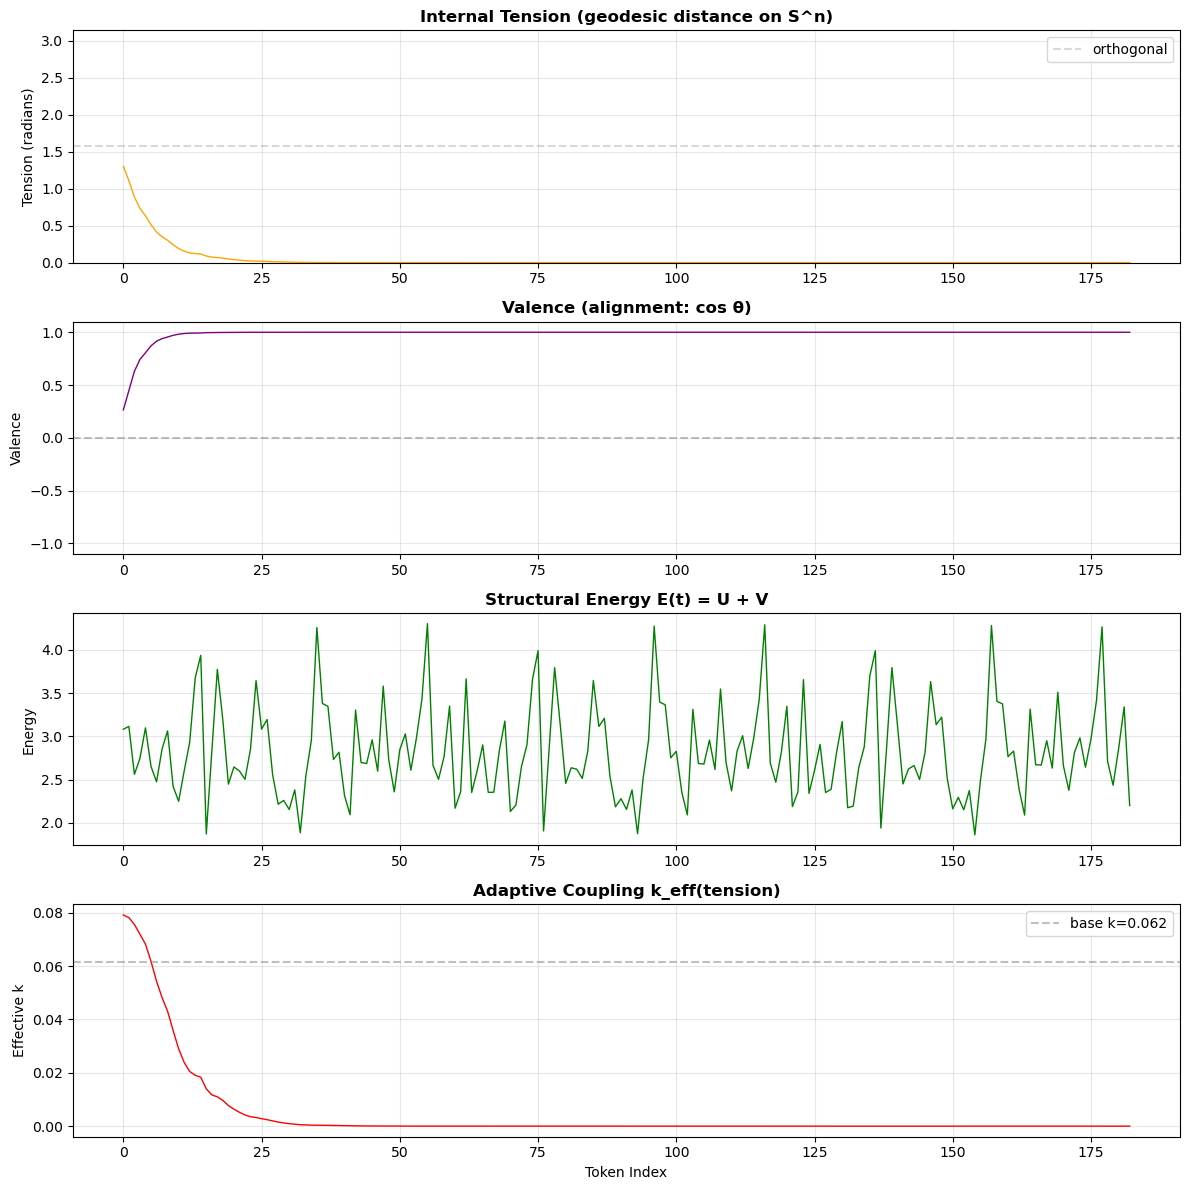

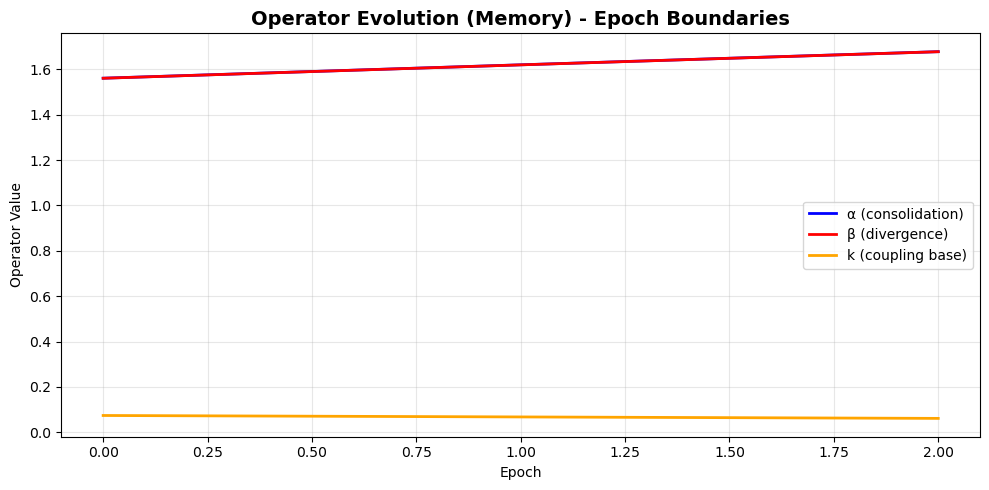

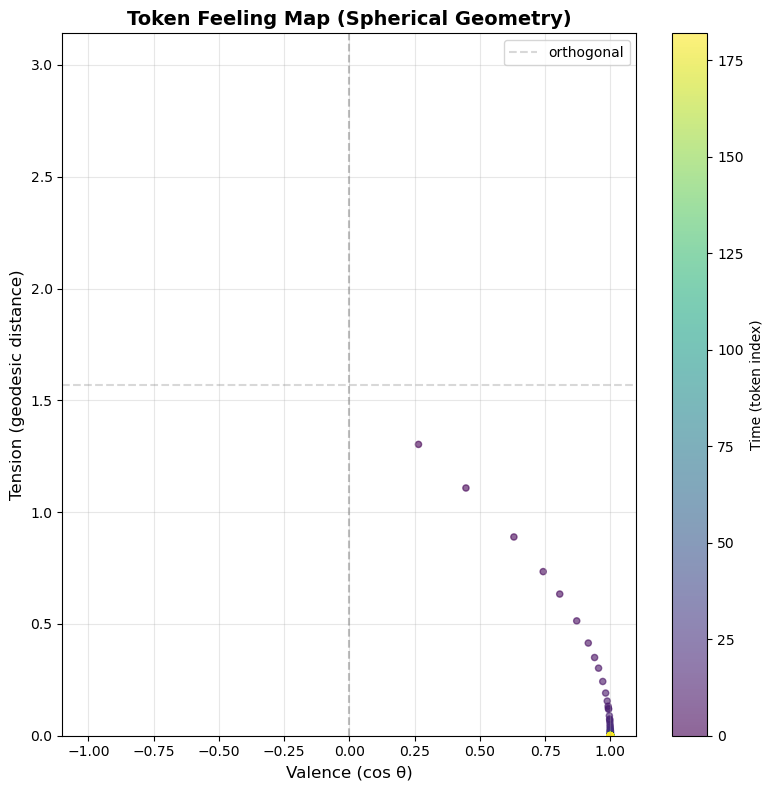

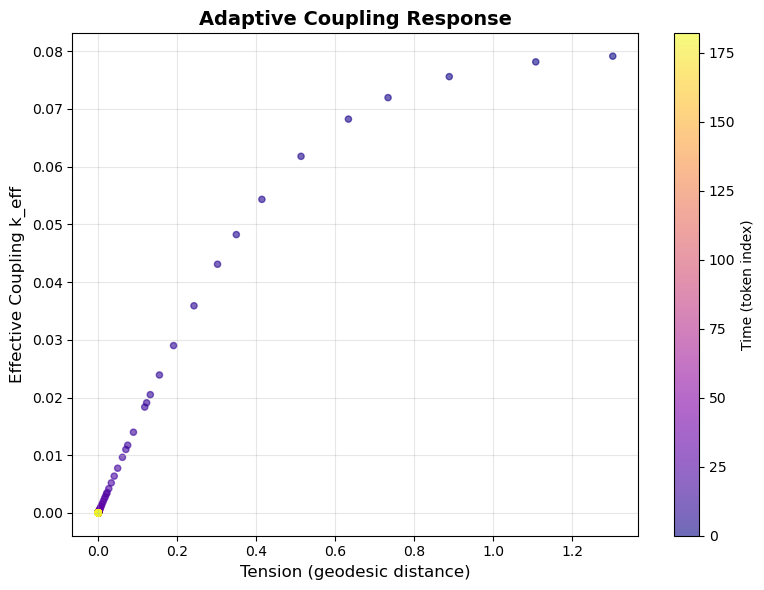


2. To load from file:
   tokens, file_type = auto_load_file('path/to/file.txt')
   organism.process_sequence(tokens, epochs=5)

3. For binary files (like enwik8):
   tokens, _ = auto_load_file('enwik8', max_size=100000)
   config = OrganismConfig()
   config.VOCAB_SIZE = 256  # for byte values
   config.ALPHA_INIT = 2.0
   config.BETA_INIT = 2.0
   organism = DualFieldOrganism(config)
   organism.process_sequence(tokens, epochs=10)

Tweak parameters in OrganismConfig class and re-run!


In [17]:
"""
Dual-Field Language Organism
A minimal implementation of feeling machines for language learning

Based on: "An Outline of a Theory of Feelings and Feeling Machines"
by Pasquale Caianiello

This notebook implements a dual-field organism that learns language
through the tension between consolidation (φ) and divergence (ψ).

KEY FEATURES: 
- Fields live on unit sphere (S^n) - self-regulating geometry
- Adaptive coupling based on current tension - endogenous regulation
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import struct

# ============================================================================
# TWEAKING PARAMETERS - ADJUST THESE TO EXPERIMENT
# ============================================================================

class OrganismConfig:
    """
    All adjustable parameters in one place for easy experimentation
    """
    # Field dimension and vocabulary
    DIM = 64                    # Dimensionality of state space
    VOCAB_SIZE = 1000          # Maximum vocabulary size
    
    # Initial operator values (will adapt during learning)
    ALPHA_INIT = 1.5           # Initial consolidation strength
    BETA_INIT = 1.5            # Initial divergence strength
    LAMBDA_INIT = 0.1          # Initial phi recruitment bias
    MU_INIT = 0.1              # Initial psi recruitment bias
    K_INIT = 0.08              # Initial coupling strength (base value)
    
    # Adaptive coupling parameters
    ADAPTIVE_COUPLING = True   # Enable tension-modulated coupling?
    COUPLING_SCALE = 2.0       # Scale factor for tanh in adaptive coupling
    
    # Dynamics integration
    DT = 0.03                  # Time step for integration
    INTEGRATION_STEPS = 5      # Number of steps per token
    
    # Operator adaptation
    CONTINUOUS_ADAPTATION = True   # Adapt operators every token (true memory)?
    LEARNING_RATE_FAST = 0.0001    # Per-token adaptation rate (small!)
    LEARNING_RATE_SLOW = 0.01      # Per-epoch adaptation rate
    ADAPTATION_WINDOW = 100        # Number of recent tokens to average for adaptation
    
    # Optional: Momentum (set to 0 to disable)
    USE_MOMENTUM = False       # Enable momentum/inertia?
    MOMENTUM_FACTOR = 0.7      # Momentum coefficient (0 = no momentum, 1 = all momentum)


# ============================================================================
# FILE LOADING UTILITIES
# ============================================================================

def load_text_file(filepath: str, max_chars: Optional[int] = None) -> str:
    """Load a text file (handles UTF-8, Latin-1, etc.)"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
    
    for encoding in encodings:
        try:
            with open(filepath, 'r', encoding=encoding) as f:
                text = f.read()
                if max_chars:
                    text = text[:max_chars]
                return text
        except UnicodeDecodeError:
            continue
    
    raise ValueError(f"Could not decode file {filepath} with any known encoding")


def load_binary_file(filepath: str, max_bytes: Optional[int] = None) -> bytes:
    """Load a binary file as raw bytes"""
    with open(filepath, 'rb') as f:
        data = f.read()
        if max_bytes:
            data = data[:max_bytes]
        return data


def load_csv_as_text(filepath: str, max_rows: Optional[int] = None) -> str:
    """Load CSV and convert to text (concatenate all cells)"""
    import csv
    
    text_parts = []
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if max_rows and i >= max_rows:
                break
            text_parts.append(' '.join(row))
    
    return ' '.join(text_parts)


def auto_load_file(filepath: str, max_size: int = 1_000_000) -> Tuple[List, str]:
    """
    Automatically detect file type and load as tokens
    Returns: (tokens, file_type)
    """
    path = Path(filepath)
    suffix = path.suffix.lower()
    
    if suffix == '.txt':
        text = load_text_file(filepath, max_size)
        tokens = tokenize_text(text)
        return tokens, 'text'
    
    elif suffix == '.csv':
        text = load_csv_as_text(filepath, max_size // 100)
        tokens = tokenize_text(text)
        return tokens, 'csv'
    
    else:
        # Treat as binary - use byte values as tokens
        data = load_binary_file(filepath, max_size)
        tokens = list(data)
        return tokens, 'binary'


def tokenize_text(text: str, method: str = 'word') -> List[str]:
    """
    Tokenize text into tokens
    method: 'word' (split on whitespace/punctuation) or 'char' (character-level)
    """
    if method == 'char':
        return list(text)
    
    # Simple word tokenizer
    import re
    tokens = re.findall(r'\w+|[^\w\s]', text.lower())
    return tokens


# ============================================================================
# GEOMETRIC UTILITIES
# ============================================================================

def normalize_to_sphere(x: np.ndarray) -> np.ndarray:
    """Project vector onto unit sphere"""
    norm = np.linalg.norm(x)
    if norm < 1e-10:  # Handle zero vector
        return x
    return x / norm


def geodesic_distance(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute geodesic (great circle) distance between two points on unit sphere
    This is the natural notion of distance when fields live on S^n
    """
    # Ensure on sphere
    x = normalize_to_sphere(x)
    y = normalize_to_sphere(y)
    
    # Compute angle via dot product
    dot = np.clip(np.dot(x, y), -1.0, 1.0)
    return np.arccos(dot)


# ============================================================================
# DUAL-FIELD ORGANISM (SPHERICAL VERSION WITH ADAPTIVE COUPLING)
# ============================================================================

class DualFieldOrganism:
    """
    A minimal dual-field organism for language learning
    
    Fields:
        X_phi: consolidation field (pulls toward familiar patterns) - lives on S^n
        X_psi: divergence field (pushes toward novelty) - lives on S^n
    
    Operators (adaptive):
        alpha: consolidation strength
        beta: divergence strength
        lambda_: phi recruitment bias
        mu: psi recruitment bias
        k: coupling strength between fields
    
    KEY: 
    - Fields are constrained to unit sphere - self-regulating geometry
    - Coupling adapts based on current tension - endogenous regulation
    """
    
    def __init__(self, config: OrganismConfig = None):
        if config is None:
            config = OrganismConfig()
        
        self.config = config
        self.dim = config.DIM
        self.vocab_size = config.VOCAB_SIZE
        
        # Dual fields - initialize on sphere
        self.X_phi = normalize_to_sphere(np.random.randn(self.dim))
        self.X_psi = normalize_to_sphere(np.random.randn(self.dim))
        
        # Momentum (if enabled)
        self.velocity_phi = np.zeros(self.dim)
        self.velocity_psi = np.zeros(self.dim)
        
        # Operators (will adapt over time)
        self.alpha = config.ALPHA_INIT
        self.beta = config.BETA_INIT
        self.lambda_ = config.LAMBDA_INIT
        self.mu = config.MU_INIT
        self.k = config.K_INIT
        
        # Vocabulary and embeddings (also on sphere)
        self.vocab = {}
        self.embeddings = {}
        
        # History
        self.feeling_history = []
        self.energy_history = []
        self.operator_history = []
        self.coupling_history = []  # Track effective coupling
        
    def build_vocabulary(self, tokens: List):
        """Build vocabulary and random embeddings from tokens (on sphere)"""
        unique_tokens = list(set(tokens))[:self.vocab_size]
        
        self.vocab = {token: i for i, token in enumerate(unique_tokens)}
        self.embeddings = {
            token: normalize_to_sphere(np.random.randn(self.dim))
            for token in unique_tokens
        }
        
        print(f"Vocabulary size: {len(self.vocab)}")
        
    def get_embedding(self, token) -> np.ndarray:
        """Get embedding for a token (or random direction if unknown)"""
        if token not in self.embeddings:
            return normalize_to_sphere(np.random.randn(self.dim))
        return self.embeddings[token]
    
    def compute_potentials(self, token_embedding: np.ndarray) -> Tuple[float, float, float]:
        """
        Compute U (consolidation), V (divergence), and total energy E
        
        On the sphere, we use geodesic distance instead of Euclidean
        U penalizes angular distance from token (wants to align)
        V rewards angular distance from token (wants to diverge)
        """
        # Geodesic distances
        dist_phi = geodesic_distance(self.X_phi, token_embedding)
        dist_psi = geodesic_distance(self.X_psi, token_embedding)
        
        # U: consolidation potential (penalizes distance)
        U = self.alpha * (dist_phi ** 2) - self.lambda_
        
        # V: divergence potential (rewards distance)
        V = self.beta * (dist_psi ** 2) - self.mu
        
        E = U + V
        return U, V, E
    
    def compute_tangent_gradients(self, token_embedding: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute gradients in tangent space to sphere
        This ensures the dynamics stay on the manifold
        """
        # Direction toward/away from token (projected to tangent space)
        toward_token_phi = token_embedding - np.dot(self.X_phi, token_embedding) * self.X_phi
        toward_token_psi = token_embedding - np.dot(self.X_psi, token_embedding) * self.X_psi
        
        # Normalize to tangent vectors
        norm_phi = np.linalg.norm(toward_token_phi)
        norm_psi = np.linalg.norm(toward_token_psi)
        
        if norm_phi > 1e-10:
            toward_token_phi = toward_token_phi / norm_phi
        if norm_psi > 1e-10:
            toward_token_psi = toward_token_psi / norm_psi
        
        # Consolidation gradient: toward token
        grad_U_tangent = -2 * self.alpha * geodesic_distance(self.X_phi, token_embedding) * toward_token_phi
        
        # Divergence gradient: away from token  
        grad_V_tangent = 2 * self.beta * geodesic_distance(self.X_psi, token_embedding) * toward_token_psi
        
        return grad_U_tangent, grad_V_tangent
    
    def compute_adaptive_coupling(self, current_tension: float) -> float:
        """
        Compute adaptive coupling strength based on current field tension
        
        Uses tanh to create smooth, bounded coupling:
        - When fields collapse (tension → 0): coupling → 0 (let them explore)
        - When fields diverge (tension → π): coupling → k (pull them back)
        
        This is pure endogenous regulation - no external parameters
        """
        if not self.config.ADAPTIVE_COUPLING:
            return self.k
        
        # tanh provides smooth transition from 0 to k
        k_effective = self.k * np.tanh(self.config.COUPLING_SCALE * current_tension)
        
        return k_effective
    
    def step_dynamics(self, token_embedding: np.ndarray):
        """
        Run dual-field dynamics for several timesteps ON THE SPHERE
        
        Equations (in tangent space):
            dX_phi/dt = -∇U(X_phi) + k_eff * project_tangent(X_psi - X_phi)
            dX_psi/dt = +∇V(X_psi) - k_eff * project_tangent(X_psi - X_phi)
        
        After each step, renormalize to stay on sphere
        
        With adaptive coupling: k_eff = k * tanh(scale * tension)
        """
        dt = self.config.DT
        steps = self.config.INTEGRATION_STEPS
        
        for _ in range(steps):
            # Compute current tension for adaptive coupling
            current_tension = geodesic_distance(self.X_phi, self.X_psi)
            k_eff = self.compute_adaptive_coupling(current_tension)
            
            # Compute gradients
            grad_U, grad_V = self.compute_tangent_gradients(token_embedding)
            
            # Field difference projected to tangent spaces
            D_phi = self.X_psi - np.dot(self.X_phi, self.X_psi) * self.X_phi  # tangent at phi
            D_psi = self.X_phi - np.dot(self.X_psi, self.X_phi) * self.X_psi  # tangent at psi
            
            # Dual-field equations with adaptive coupling
            dX_phi = -grad_U + k_eff * D_phi
            dX_psi = grad_V - k_eff * D_psi
            
            # Apply momentum if enabled
            if self.config.USE_MOMENTUM:
                self.velocity_phi = self.config.MOMENTUM_FACTOR * self.velocity_phi + (1 - self.config.MOMENTUM_FACTOR) * dX_phi
                self.velocity_psi = self.config.MOMENTUM_FACTOR * self.velocity_psi + (1 - self.config.MOMENTUM_FACTOR) * dX_psi
                
                self.X_phi += dt * self.velocity_phi
                self.X_psi += dt * self.velocity_psi
            else:
                # Direct Euler integration
                self.X_phi += dt * dX_phi
                self.X_psi += dt * dX_psi
            
            # Renormalize to sphere (self-regulation)
            self.X_phi = normalize_to_sphere(self.X_phi)
            self.X_psi = normalize_to_sphere(self.X_psi)
        
        # Record final effective coupling for this token
        final_tension = geodesic_distance(self.X_phi, self.X_psi)
        final_k_eff = self.compute_adaptive_coupling(final_tension)
        self.coupling_history.append(final_k_eff)
    
    def compute_feeling(self) -> Dict[str, float]:
        """
        Compute the organism's current feeling
        
        On sphere:
            tension: geodesic distance between fields (angular separation)
            valence: signed projection (which field dominates direction)
        """
        # Geodesic distance as tension
        tension = geodesic_distance(self.X_phi, self.X_psi)
        
        # Valence: dot product (positive = aligned, negative = opposed)
        valence = np.dot(self.X_phi, self.X_psi)
        
        return {'tension': tension, 'valence': valence}
    
    def adapt_operators_continuous(self, token_embedding: np.ndarray):
        """
        Continuous operator adaptation - happens every token
        This is where true memory formation occurs
        
        Operators drift based on how well fields match current token:
        - If φ consistently misses, α strengthens (more consolidation force)
        - If ψ consistently misses, β strengthens (more divergence force)
        - If tension is off-target, k adjusts
        """
        if not self.config.CONTINUOUS_ADAPTATION:
            return
        
        eta = self.config.LEARNING_RATE_FAST
        
        # Measure mismatch for each field
        dist_phi = geodesic_distance(self.X_phi, token_embedding)
        dist_psi = geodesic_distance(self.X_psi, token_embedding)
        
        # α increases when φ is far from target (needs more consolidation)
        self.alpha += eta * dist_phi
        self.alpha = np.clip(self.alpha, 0.1, 5.0)  # Keep bounded
        
        # β increases when ψ is far from target (needs more divergence)
        self.beta += eta * dist_psi
        self.beta = np.clip(self.beta, 0.1, 5.0)
        
        # k adjusts based on current tension vs desired metastability
        tension = geodesic_distance(self.X_phi, self.X_psi)
        target_tension = np.pi / 3  # Target: fields should be ~60° apart
        self.k += eta * (tension - target_tension) * 0.1
        self.k = np.clip(self.k, 0.01, 1.0)
    
    def process_token(self, token) -> Dict[str, float]:
        """Process a single token and return feelings"""
        embedding = self.get_embedding(token)
        
        # Run dynamics
        self.step_dynamics(embedding)
        
        # Continuous adaptation (true memory formation)
        self.adapt_operators_continuous(embedding)
        
        # Compute feelings
        feelings = self.compute_feeling()
        U, V, E = self.compute_potentials(embedding)
        
        # Record history
        self.feeling_history.append({
            'token': token,
            'tension': feelings['tension'],
            'valence': feelings['valence'],
            'energy': E
        })
        self.energy_history.append(E)
        
        return {**feelings, 'energy': E}
    
    def adapt_operators_epoch(self):
        """
        Slow operator adaptation at epoch boundaries (optional)
        Complements continuous adaptation with larger adjustments
        """
        if len(self.energy_history) < 10:
            return
        
        # Use recent average energy for gradient
        window = min(self.config.ADAPTATION_WINDOW, len(self.energy_history))
        recent_energy = np.mean(self.energy_history[-window:])
        
        # Larger adjustments based on accumulated energy
        lr = self.config.LEARNING_RATE_SLOW
        self.alpha = max(0.1, self.alpha - lr * recent_energy * 0.01)
        self.beta = max(0.1, self.beta - lr * recent_energy * 0.01)
        
        # Record operator state
        self.operator_history.append({
            'alpha': self.alpha,
            'beta': self.beta,
            'k': self.k
        })
    
    def process_sequence(self, tokens: List, epochs: int = 1, verbose: bool = True):
        """Process a sequence of tokens for multiple epochs"""
        if not self.vocab:
            self.build_vocabulary(tokens)
        
        for epoch in range(epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{epochs}")
            
            for i, token in enumerate(tokens):
                self.process_token(token)
                
                if verbose and i % 100 == 0:
                    recent = self.feeling_history[-1]
                    k_eff = self.coupling_history[-1] if self.coupling_history else self.k
                    print(f"  Token {i}/{len(tokens)}: "
                          f"tension={recent['tension']:.4f}, "
                          f"valence={recent['valence']:.4f}, "
                          f"energy={recent['energy']:.4f}, "
                          f"k_eff={k_eff:.4f}")
            
            # Adapt operators at end of epoch (slow adjustment)
            self.adapt_operators_epoch()
            
            if verbose:
                print(f"  Adapted operators: α={self.alpha:.4f}, β={self.beta:.4f}")


# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_feelings(organism: DualFieldOrganism, window: int = 500):
    """Plot the organism's feeling trajectory"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    
    indices = range(len(history))
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    energies = [h['energy'] for h in history]
    couplings = organism.coupling_history[-window:] if len(organism.coupling_history) >= window else organism.coupling_history
    
    # Tension (geodesic distance)
    axes[0].plot(indices, tensions, color='orange', linewidth=1)
    axes[0].set_title('Internal Tension (geodesic distance on S^n)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Tension (radians)')
    axes[0].set_ylim([0, np.pi])
    axes[0].axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # Valence (dot product)
    axes[1].plot(indices, valences, color='purple', linewidth=1)
    axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Valence (alignment: cos θ)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Valence')
    axes[1].set_ylim([-1.1, 1.1])
    axes[1].grid(alpha=0.3)
    
    # Energy
    axes[2].plot(indices, energies, color='green', linewidth=1)
    axes[2].set_title('Structural Energy E(t) = U + V', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Energy')
    axes[2].grid(alpha=0.3)
    
    # Effective coupling (adaptive)
    if len(couplings) > 0:
        axes[3].plot(range(len(couplings)), couplings, color='red', linewidth=1)
        axes[3].axhline(organism.k, color='gray', linestyle='--', alpha=0.5, label=f'base k={organism.k:.3f}')
        axes[3].set_title('Adaptive Coupling k_eff(tension)', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Token Index')
        axes[3].set_ylabel('Effective k')
        axes[3].grid(alpha=0.3)
        axes[3].legend()
    
    plt.tight_layout()
    plt.show()


def plot_operators(organism: DualFieldOrganism, continuous: bool = True):
    """
    Plot operator evolution
    If continuous=True, plots per-token evolution from feeling history
    If continuous=False, plots per-epoch from operator history
    """
    if continuous and len(organism.feeling_history) > 0:
        # Reconstruct continuous operator evolution
        # We need to track operators at each token for this
        # For now, show epoch-based if available
        if len(organism.operator_history) > 0:
            plot_epoch_operators(organism)
        else:
            print("Process at least one full epoch to see operator evolution")
    else:
        plot_epoch_operators(organism)


def plot_epoch_operators(organism: DualFieldOrganism):
    """Plot operator evolution over epochs"""
    history = organism.operator_history
    
    if len(history) == 0:
        print("No operator history to plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    epochs = range(len(history))
    alphas = [h['alpha'] for h in history]
    betas = [h['beta'] for h in history]
    ks = [h['k'] for h in history]
    
    ax.plot(epochs, alphas, label='α (consolidation)', color='blue', linewidth=2)
    ax.plot(epochs, betas, label='β (divergence)', color='red', linewidth=2)
    ax.plot(epochs, ks, label='k (coupling base)', color='orange', linewidth=2)
    
    ax.set_title('Operator Evolution (Memory) - Epoch Boundaries', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Operator Value')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_feeling_distribution(organism: DualFieldOrganism, window: int = 500):
    """Plot 2D distribution of feelings (tension vs valence)"""
    history = organism.feeling_history[-window:]
    
    if len(history) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history]
    valences = [h['valence'] for h in history]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    scatter = ax.scatter(valences, tensions, c=range(len(tensions)), 
                        cmap='viridis', alpha=0.6, s=20)
    
    ax.set_xlabel('Valence (cos θ)', fontsize=12)
    ax.set_ylabel('Tension (geodesic distance)', fontsize=12)
    ax.set_title('Token Feeling Map (Spherical Geometry)', fontsize=14, fontweight='bold')
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(np.pi/2, color='gray', linestyle='--', alpha=0.3, label='orthogonal')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([0, np.pi])
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


def plot_coupling_vs_tension(organism: DualFieldOrganism, window: int = 500):
    """Plot relationship between tension and effective coupling"""
    history = organism.feeling_history[-window:]
    couplings = organism.coupling_history[-window:]
    
    if len(history) == 0 or len(couplings) == 0:
        print("No history to plot")
        return
    
    tensions = [h['tension'] for h in history[:len(couplings)]]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    scatter = ax.scatter(tensions, couplings, c=range(len(tensions)), 
                        cmap='plasma', alpha=0.6, s=20)
    
    ax.set_xlabel('Tension (geodesic distance)', fontsize=12)
    ax.set_ylabel('Effective Coupling k_eff', fontsize=12)
    ax.set_title('Adaptive Coupling Response', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    plt.colorbar(scatter, label='Time (token index)', ax=ax)
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("=" * 70)
    print("Dual-Field Language Organism - Spherical with Adaptive Coupling")
    print("=" * 70)
    print("\nCurrent Configuration:")
    print(f"  Dimension: {OrganismConfig.DIM}")
    print(f"  Initial α: {OrganismConfig.ALPHA_INIT}, β: {OrganismConfig.BETA_INIT}")
    print(f"  Initial k: {OrganismConfig.K_INIT}")
    print(f"  Adaptive coupling: {OrganismConfig.ADAPTIVE_COUPLING}")
    print(f"  Continuous adaptation: {OrganismConfig.CONTINUOUS_ADAPTATION}")
    print(f"  Learning rates: fast={OrganismConfig.LEARNING_RATE_FAST}, slow={OrganismConfig.LEARNING_RATE_SLOW}")
    print(f"  Integration: dt={OrganismConfig.DT}, steps={OrganismConfig.INTEGRATION_STEPS}")
    print(f"  Momentum: {OrganismConfig.USE_MOMENTUM}")
    print("=" * 70)
    
    # Example 1: Simple text
    print("\n1. Processing simple text...")
    text = """
    The quick brown fox jumps over the lazy dog.
    This is a test of the dual-field language organism.
    It learns not by prediction, but by feeling the tension
    between familiar patterns and novel structures.
    The fields live on a sphere and self-regulate through geometry.
    Adaptive coupling prevents both collapse and explosion.
    """
    
    tokens = tokenize_text(text)
    
    # Create organism with default config (or customize)
    config = OrganismConfig()
    config.CONTINUOUS_ADAPTATION = True
    config.LEARNING_RATE_FAST = 0.001  # Try larger to see changes more clearly

    # config.ALPHA_INIT = 2.0  # Uncomment to customize
    # config.ADAPTIVE_COUPLING = False  # Uncomment to disable adaptive coupling
    
    organism = DualFieldOrganism(config)
    organism.process_sequence(tokens, epochs=3, verbose=True)
    
    plot_feelings(organism)
    plot_operators(organism)
    plot_feeling_distribution(organism)
    plot_coupling_vs_tension(organism)
    
    # Example 2: Load from file
    print("\n2. To load from file:")
    print("   tokens, file_type = auto_load_file('path/to/file.txt')")
    print("   organism.process_sequence(tokens, epochs=5)")
    
    # Example 3: Binary data (like enwik8)
    print("\n3. For binary files (like enwik8):")
    print("   tokens, _ = auto_load_file('enwik8', max_size=100000)")
    print("   config = OrganismConfig()")
    print("   config.VOCAB_SIZE = 256  # for byte values")
    print("   config.ALPHA_INIT = 2.0")
    print("   config.BETA_INIT = 2.0")
    print("   organism = DualFieldOrganism(config)")
    print("   organism.process_sequence(tokens, epochs=10)")
    
    print("\n" + "=" * 70)
    print("Tweak parameters in OrganismConfig class and re-run!")
    print("=" * 70)